# Beat The Bookies: Predicting EPL Matches
_Team C_

__Mohammad Ali Syed, Abdul Al-Fahim, Dylan Hoi, Henry Chen, Chris Wong & Yolanne Lee__

**Contents:**

[Section 1](#section1): Introduction

[Section 2](#section2): Data Import

[Section 3](#section3): Data Transformation & Exploration

[Section 4](#section4): Methodology Overview

[Section 5](#section5): Model Training & Validation

[Section 6](#section6): Results

[Section 7](#section7): Final Predictions on Test Set

## Introduction
<a name='section1'></a>

## Data Import
<a name='section2'></a>

In [114]:
#Import packages
import math
import numpy as np
import pandas as pd
import datetime as datetime
import seaborn as sns
from collections import Counter, deque

#!pip install geopy
#!pip install sklearn

#For Computing Priors
from geopy.distance import geodesic 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report,confusion_matrix, accuracy_score


#For Visualisation
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

#For Model Selection
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt


In [104]:
# Import Data

# EPL Training Data
dirName = 'Data_Files/'
filePath = dirName + 'epl-training.csv'
data = pd.read_csv(filePath)

# Additional EPL Training Data
# downloaded from www.football-stats.co.uk and concatenated from seasons 2000-2008.
# Reformatted to suit our current data architecture, additional 3,047 rows x 22 columns
filePath = dirName + 'epl-training-extra.csv'
extraData = pd.read_csv(filePath)
#data = data.append(extraData, ignore_index = True) #append additional data

# Additional EPL Stadium Location Data
filePath = dirName + 'epl-stadium.csv'
locationData = pd.read_csv(filePath)

#Remove empty nan columns at the end
data = data.iloc[:, 0:22]
pd.set_option('display.max_columns', None)
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,19/08/2000,Charlton,Man City,4,0,H,2,0,H,Rob Harris,17,8,14,4,13,12,6,6,1,2,0,0
1,19/08/2000,Chelsea,West Ham,4,2,H,1,0,H,Graham Barber,17,12,10,5,19,14,7,7,1,2,0,0
2,19/08/2000,Coventry,Middlesbrough,1,3,A,1,1,D,Barry Knight,6,16,3,9,15,21,8,4,5,3,1,0
3,19/08/2000,Derby,Southampton,2,2,D,1,2,A,Andy D'Urso,6,13,4,6,11,13,5,8,1,1,0,0
4,19/08/2000,Leeds,Everton,2,0,H,2,0,H,Dermot Gallagher,17,12,8,6,21,20,6,4,1,3,0,0


## Data Transformation & Exploration
<a name='section3'></a>

In [ ]:
#Helper Functions

def corr_matrix(X, feature):
    corr= X.corr()
    corr_y = abs(corr[feature])
    highest_corr = corr_y[corr_y >0.2]
    highest_corr.sort_values(ascending=True)
    return highest_corr

def rf_model(X_train, X_test, y_train, y_test):
    rf=RandomForestClassifier(random_state = 42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    accuracy = calc_accuracy(preds, y_test)
    return rf, preds, accuracy

def feat_importances(X_train, rf):
    feature_importances = list(zip(X_train, rf.feature_importances_))
    feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    return feature_importances_ranked

def select_feat(X_train, y_train):
    feature_selector = SelectFromModel(RandomForestClassifier(random_state = 42)).fit(X_train, y_train)
    selected_feat= X_train.columns[(feature_selector.get_support())]
    return selected_feat

def calc_accuracy(preds, labels):
    accuracy = accuracy_score(labels, preds) * 100
    return accuracy

def rf_tree_visualiser(rf, featuresetName, feature_names):
    tree = rf.estimators_[10]  #Take 10th random tree
    export_graphviz(tree, out_file = featuresetName + '.dot', feature_names = list(feature_names),
                    rounded = True, proportion = False, 
                    precision = 2, filled = True, max_depth = 3)
    call(['dot', '-Tpng', featuresetName + '.dot', '-o', featuresetName + '.png'],shell=True)
    return featuresetName + '.png'

def scatter(data, title, xlabel, ylabel):
    # Assume data is an array of tuples
    x, y = zip(*data)
    # s is the area of the circles in the plot
    plt.scatter(x, y, s=50)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
# https://towardsdatascience.com/stop-one-hot-encoding-your-time-based-features-24c699face2f
def transformation(column):
    max_value = column.max()
    sin_values = [math.sin((2*math.pi*x)/max_value) for x in list(column)]
    cos_values = [math.cos((2*math.pi*x)/max_value) for x in list(column)]
    return sin_values, cos_values

In [ ]:
############################################# Feature Visualisation
# Visualise correlations between different statistics
from pandas.plotting import scatter_matrix

# Sort data by teams
teams = {}
referees = {}
for i in data.groupby('HomeTeam').mean().T.columns:
    teams[i] = []
for i in data.groupby('Referee').mean().T.columns:
    referees[i] = []

# Team Summary Statistics
home_team_stats = pd.DataFrame()
away_team_stats = pd.DataFrame()

teams = pd.unique(data[["HomeTeam"]].values.ravel())

for team in teams:
    # Compute summary stats as home team
    team_stats = data[(data["HomeTeam"] == team)]
    team_stats = team_stats.iloc[:, [3, 6, 10, 12, 14, 16, 18, 20]]
    team_stats = team_stats.sum()

    performance = data[(data["HomeTeam"] == team)].iloc[:, 5]
    num_vals = len(performance)
    
    performance = performance.value_counts()
    performance_keys = performance.keys()
    performance_values = performance.values
    performance = zip(performance.keys(), performance.values)
    
    for key, value in performance:
        metric = value/num_vals
        
        if key == "H":
            team_stats["Win Rate"] = metric
            
        elif key == "A":
            team_stats["Lose Rate"] = metric
        
        else:
            team_stats["Draw Rate"] = metric

    home_team_stats[team] = pd.DataFrame(team_stats) ##causing problems

    # Compute summary stats as away team
    team_stats = data[(data["AwayTeam"] == team)]
    team_stats = team_stats.iloc[:, [4, 7, 11, 13, 15, 17, 19, 21]]
    team_stats = team_stats.sum()

    performance = data[(data["AwayTeam"] == team)].iloc[:, 5]
    num_vals = len(performance)

    performance = performance.value_counts()
    performance_keys = performance.keys()
    performance_values = performance.values
    performance = zip(performance.keys(), performance.values)
    
    for key, value in performance:
        metric = value/num_vals
        
        if key == "A":
            team_stats["Win Rate"] = metric
            
        elif key == "H":
            team_stats["Lose Rate"] = metric
        
        else:
            team_stats["Draw Rate"] = metric


    away_team_stats[team] = pd.DataFrame(team_stats)

# Sort by strongest to weakest team, by win rate
home_team_stats = home_team_stats.sort_values(by='Win Rate', axis=1, ascending=False)
away_team_stats = away_team_stats.sort_values(by='Win Rate', axis=1, ascending=False)
home_team_stats
#Interesting to note, Man U ranked lower on every metric except fouls and yellow cards compared to Chelsea but had higher win rate -> could suggest the more aggressive the team, the higher the win rate
# print(home_team_stats.iloc[:, 0])
# print(away_team_stats.iloc[:, 0])
# print(np.array(home_team_stats.iloc[:, 0]) - np.array(away_team_stats.iloc[:, 0]))

In [ ]:
#Correlation matrix between full time goals and other features
highest_corr = corr_matrix(data, "FTHG")
print("FTHG: \n" + str(highest_corr))

highest_corr = corr_matrix(data, "FTAG")
print("FTAG: \n" + str(highest_corr))

In [ ]:
#Split dataset into input and output data

#Output variable
y = data.iloc[:, 5:6]
#Reformat y to make it suitable for LabelEncoder

y = np.array(y).reshape(len(y))
# #Encode y
# y = LabelEncoder().fit_transform(y) #################this needs to be done separately for train/test

#Input variables
#Remove give away columns such as goals scored
data_filtered = data.drop(labels = data.columns[[3, 4, 5, 6, 7, 8]], axis = 1)

In [ ]:
#Data preprocessing

#Dates
data_filtered['Date'] = pd.to_datetime(data_filtered['Date'])
#year has been removed as we need to predict future results -> https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96
year = data_filtered['Date'].dt.year
data_filtered['Month'] = data_filtered['Date'].dt.month
data_filtered['Week'] = data_filtered['Date'].dt.isocalendar().week
data_filtered['Day'] = data_filtered['Date'].dt.day
#Extract encoded dates
dates_split = data_filtered.iloc[:, 16:19]
#Remove encoded dates and original date column
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0, 16, 17, 18]], axis = 1)

#Encode categorical data
encoder = OneHotEncoder(handle_unknown='ignore')

#Teams
home_t = data_filtered.iloc[:, 0:1]
home_t = encoder.fit_transform(home_t) #################does this need to be done separately?

away_t = data_filtered.iloc[:, 1:2]
away_t = encoder.fit_transform(away_t) #################does this need to be done separately?
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0,1]], axis = 1)

#Referees 
ref = data_filtered.iloc[:, 0:1]
ref = encoder.fit_transform(ref)       #################does this need to be done separately?
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0]], axis = 1)

#Re-stack columns
data_filtered = data_filtered.join(pd.DataFrame(ref.toarray()), rsuffix = '_ref')
data_filtered = data_filtered.join(pd.DataFrame(home_t.toarray()), rsuffix = '_home')
data_filtered = data_filtered.join(pd.DataFrame(away_t.toarray()), rsuffix = '_away')
data_filtered = dates_split.join(data_filtered)
data_filtered.columns = data_filtered.columns.astype(str)
data_filtered.head()

In [ ]:
#Train model on entire featureset
X_train, X_test, y_train, y_test = train_test_split(data_filtered, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

rf, preds, base_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on entire featureset: " + str(base_accuracy) + "%")


In [ ]:
#Print rf tree N.B. may not work without importing graphviz, random forest images will be on GitHub
Image(filename = rf_tree_visualiser(rf, 'featureSetTree', data_filtered.columns))

In [ ]:
#Train model without Referee feature
data_filtered_no_ref = data_filtered.iloc[:, 0:15].join(data_filtered.iloc[:, 58:])
X_train, X_test, y_train, y_test = train_test_split(data_filtered_no_ref, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy without Referee: " + str(accuracy) + "%")
print("Difference from before: " + str(accuracy - base_accuracy) + "%")
#Ref is having negative impact so remove
data_filtered = data_filtered_no_ref

In [ ]:
#Print rf tree (no ref)
Image(filename = rf_tree_visualiser(rf, 'featureSetTreeNoRef', data_filtered_no_ref.columns))

In [ ]:
#Train model without Date feature
data_filtered_no_date = data_filtered.iloc[:, 3:]
X_train, X_test, y_train, y_test = train_test_split(data_filtered_no_date, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy without Dates: " + str(accuracy) + "%")
print("Difference from before: " + str(accuracy - base_accuracy) + "%")

In [ ]:
#Print rf tree (no dates)
Image(filename = rf_tree_visualiser(rf, 'featureSetTreeNoDate', data_filtered_no_date.columns))

In [ ]:
#Train model on only in-game stats to identify most important ones
data_filtered_only_game_stats = data_filtered.iloc[:, 3:15]
X_train, X_test, y_train, y_test = train_test_split(data_filtered_only_game_stats, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, all_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on all in-game stats: " + str(all_stats_accuracy) + "%")

In [ ]:
#Visualise and analyse initial results

#Display feature importances in descending order
feature_importances = feat_importances(X_train, rf)
print("Feature Importances: ")
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances];

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, preds))
print("\nClassification Report: ")
print(classification_report(y_test, preds))
#Important note: AF/HF rank higher than HC/AC

In [ ]:
# Visualise feature importance
scatter(feature_importances, "Feature importances", "Feature", "Importance")

In [ ]:
# plot Pearson Correlation Heatmap to see the top 10 features related to the match result FTR

def plotGraph(X_all, Y_all):

    train_data=pd.concat([X_all,Y_all],axis=1)

    #FTR correlation matrix
    plt.figure(figsize=(12,12))
    k = 11 # number of variables for heatmap
    cols = abs(train_data.astype(float).corr()).nlargest(k, 'FTR')['FTR'].index
    cm = np.corrcoef(train_data[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

attributes = data.drop(['Date','HomeTeam', 'AwayTeam', 'Referee','FTR'],1)
attributes['HTR'] = attributes['HTR'].map({'H':1,'A':0,'D':2})
label = data['FTR']
label = label.map({'H':1,'A':0,'D':2})
plotGraph(attributes,label)

In [ ]:
#Feature Selection
#change names and display selected features more nicely, ideally with their importance, gini impurity...
selected_feat = select_feat(X_train, y_train)
print(selected_feat)

In [42]:
#Train model on selected in-game stats only
indexes = []
for feat in selected_feat:
    indexes.append(data_filtered_only_game_stats.columns.get_loc(feat))
    
data_filtered_filtered_game_stats = data_filtered_only_game_stats.iloc[:, indexes]

X_train, X_test, y_train, y_test = train_test_split(data_filtered_filtered_game_stats, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, reduced_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on reduced in-game stats: " + str(reduced_stats_accuracy) + "%")
print("Difference compared to all in-game stats: " + str(reduced_stats_accuracy - all_stats_accuracy) + "%")

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, preds))
print("\nClassification Report: ")
print(classification_report(y_test, preds))

Accuracy on reduced in-game stats: 54.79082321187584%
Difference compared to all in-game stats: -0.26990553306342946%

Confusion Matrix: 
[[234  39 144]
 [107  64 199]
 [118  63 514]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.51      0.56      0.53       417
           1       0.39      0.17      0.24       370
           2       0.60      0.74      0.66       695

    accuracy                           0.55      1482
   macro avg       0.50      0.49      0.48      1482
weighted avg       0.52      0.55      0.52      1482



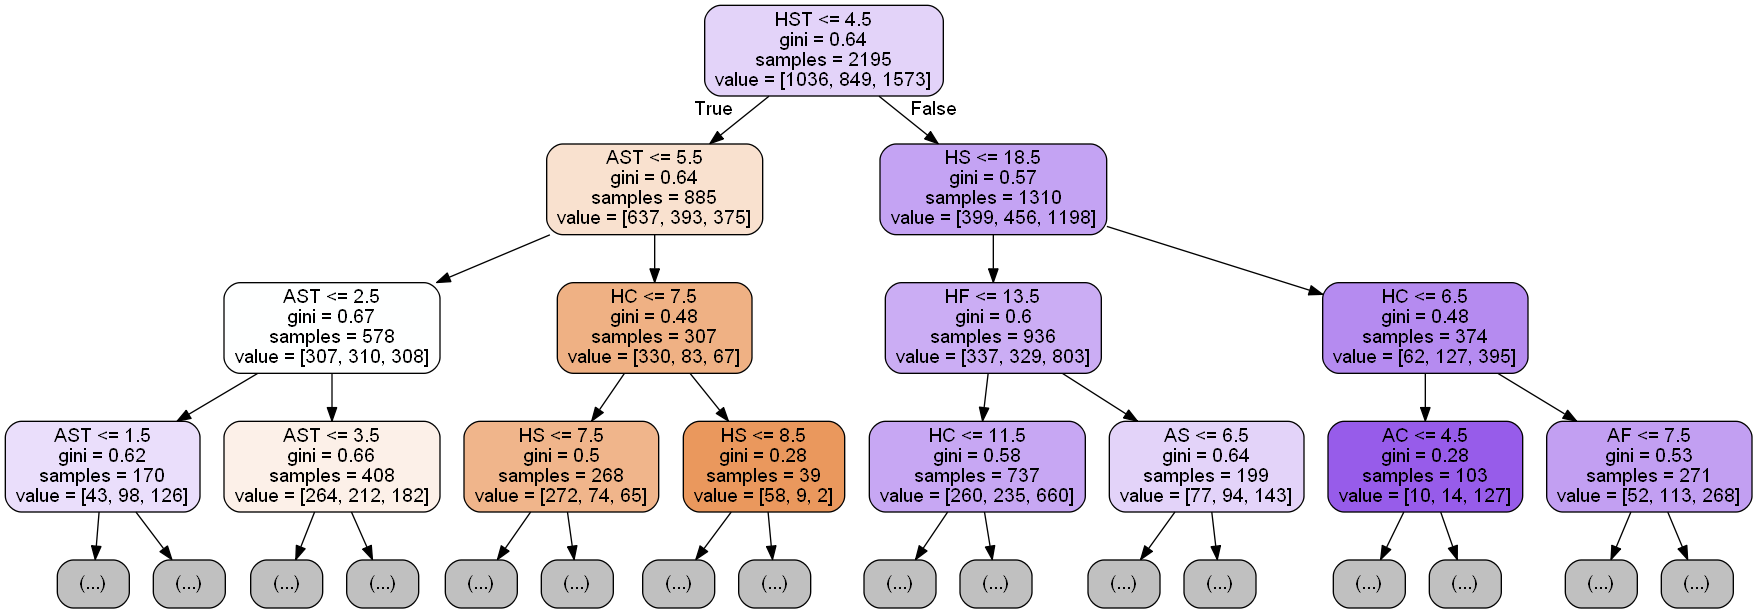

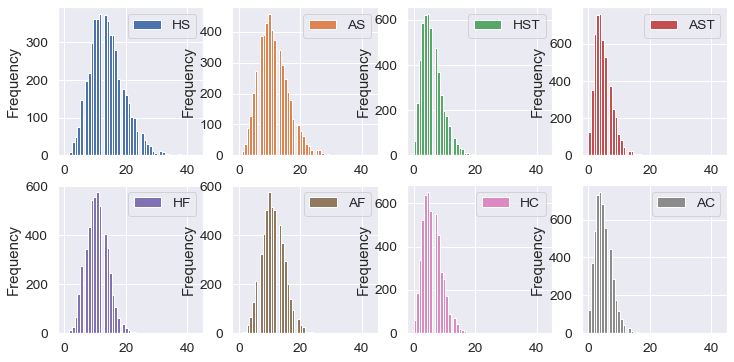

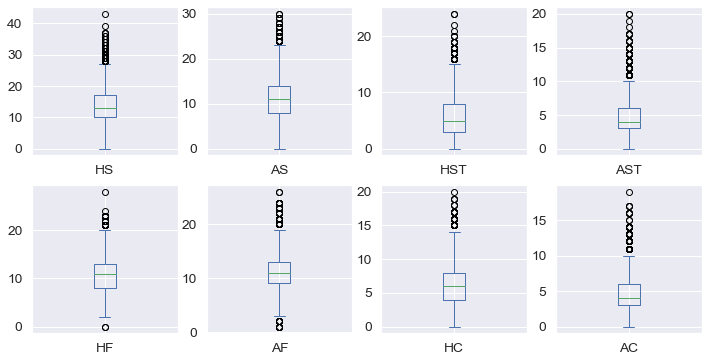

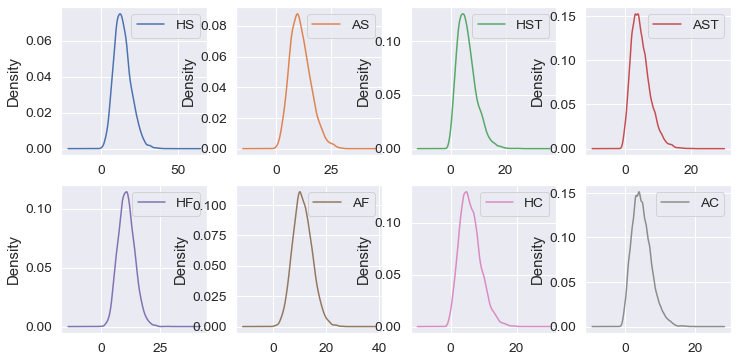

In [43]:
#Visualisation of new featureset/tree
data_filtered_filtered_game_stats.plot(kind='hist', subplots=True, sharex=False, sharey=False, bins=50, layout=(2,4), figsize=(12, 6))
data_filtered_filtered_game_stats.plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(12, 6))
data_filtered_filtered_game_stats.plot(kind='density', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(12, 6))
Image(filename = rf_tree_visualiser(rf, 'selectedFeatureSetTree', data_filtered_filtered_game_stats.columns))

In [44]:
#Produce new dataset
#Fix column names
#Restack teams and dates

#Original teams are needed to be able to compute priors
data_new = data.iloc[:, [1, 2]].join(data_filtered_filtered_game_stats)
data_new = dates_split.join(data_new)

#Stack previously removed giveaway columns
data_new = data_new.join(data.iloc[:, [3, 4, 6, 7, 8]])

#Feature engineer second half goals
#Second half home goals
SHHG = np.array(data.iloc[:, [3]]) - np.array(data.iloc[:, [6]])
#Second half away goals
SHAG = np.array(data.iloc[:, [4]]) - np.array(data.iloc[:, [7]])
data_new['SHHG'] = pd.DataFrame(SHHG)
data_new['SHAG'] = pd.DataFrame(SHAG)
data_new.columns = data_new.columns.astype(str)
data_new.head()

,Month,Week,Day,HomeTeam,AwayTeam,HS,AS,HST,AST,HF,AF,HC,AC,FTHG,FTAG,HTHG,HTAG,HTR,SHHG,SHAG
0,8,33,16,Arsenal,West Brom,24,5,14,4,11,8,7,5,1,0,1,0,H,0,0
1,8,33,16,Bolton,Stoke,14,8,8,2,13,12,4,3,3,1,3,0,H,0,1
2,8,33,16,Everton,Blackburn,10,15,5,11,11,9,3,5,2,3,1,1,D,1,2
3,8,33,16,Hull,Fulham,11,12,6,6,10,9,5,6,2,1,1,1,D,1,0
4,8,33,16,Middlesbrough,Tottenham,14,8,10,5,11,12,7,9,2,1,0,0,D,2,1


In [45]:
#See if second half goals have significant correlation to total goals
highest_corr = corr_matrix(data_new, "FTHG")
print("FTHG: \n" + str(highest_corr))

highest_corr = corr_matrix(data_new, "FTAG")
print("FTAG: \n" + str(highest_corr))
#Second half goals do have very strong correlation

FTHG: 
HS      0.291868
HST     0.447116
FTHG    1.000000
HTHG    0.686279
SHHG    0.769173
Name: FTHG, dtype: float64
FTAG: 
AS      0.329803
AST     0.455887
FTAG    1.000000
HTAG    0.689755
SHAG    0.777641
Name: FTAG, dtype: float64


## Priors Feature Construction

In [123]:
# From Pearson Correlation Heatmap to extract the top 10 features 
# there are two pairs of data highly correlated (see details in report), 
# so we just pick [FTHG, FTAG, HS, AS, HR, AR] from the top 10 features,
# additionally [Date, HomeTeam, AwayTeam, FTR], to derive our features.
selectedAttributes = ["Date","HomeTeam", "AwayTeam","FTR","FTHG","FTAG","HS","AS","HR","AR"]
training_data = data[selectedAttributes]

### 1. Cumulative Full-time W/L Ratio

In [48]:
# Computing Priors
# Calculate cumulative Full-Time win-loss ratio for Home/Away teams prior to every match
# TODO: Points-based results based on previous wins & losses 
# PHWL = Previous Home Team Win Loss Ratio
# PAWL = Previous Away Team Win Loss Ratio

def get_previousFTResults(playing_stat):
    
    # Create a dictionary with team names as keys
    teams = {}
    PHWL = []
    PAWL = []
    
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = [] #Each team gets their own list

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        
        #list of respective Home/Away team in match
        match_ht = teams[playing_stat.iloc[i].HomeTeam]
        match_at = teams[playing_stat.iloc[i].AwayTeam]
        
        #count no. of wins
        
        h_wins = Counter(match_ht)
        a_wins = Counter(match_at)
        
        #h_wins = no. of home wins
        #a_wins = no. of away wins
        h_wins = h_wins['W']
        a_wins = a_wins['W']
        
        #append W/L/D to respective teams
        
        if playing_stat.iloc[i].FTR == 'H':
            match_ht.append('W')
            match_at.append('L')
        elif playing_stat.iloc[i].FTR == 'A':
            match_at.append('W')
            match_ht.append('L')
        else:
            match_at.append('D')
            match_ht.append('D')
       
        h_wlRatio = h_wins / len(match_ht)
        a_wlRatio = a_wins / len(match_at)
        
        #Home/Away cumulative WL ratios prior to every match
        PHWL.append(h_wlRatio)
        PAWL.append(a_wlRatio)
        
    data_new.loc[:,'PHWL'] = pd.Series(PHWL)
    data_new.loc[:,'PAWL'] = pd.Series(PAWL)

    return data_new


#get_previousFTResults(data_new)

###  2. Cumulative Half-time W/L Ratio

In [49]:
# Computing Priors
# Calculate cumulative Half-Time win-loss ratio for Home/Away teams prior to every match
# HHTR = Previous Home Half Time Results
# AHTR = Previous Away Half Time Results

def get_PreviousHTResults(playing_stat):
    
    # Create a dictionary with team names as keys
    teams = {}
    HHTR = []
    AHTR = []
    
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = [] #Each team gets their own list

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        
        #list of respective Home/Away team in match
        match_ht = teams[playing_stat.iloc[i].HomeTeam]
        match_at = teams[playing_stat.iloc[i].AwayTeam]
        
        #count no. of wins
        
        h_wins = Counter(match_ht)
        a_wins = Counter(match_at)
        
        #h_wins = no. of home wins
        #a_wins = no. of away wins
        h_wins = h_wins['W']
        a_wins = a_wins['W']
        
        #append W/L/D to respective teams
        
        if playing_stat.iloc[i].HTR == 'H':
            match_ht.append('W')
            match_at.append('L')
        elif playing_stat.iloc[i].HTR == 'A':
            match_at.append('W')
            match_ht.append('L')
        else:
            match_at.append('D')
            match_ht.append('D')
            
        h_wlRatio = h_wins / len(match_ht)
        a_wlRatio = a_wins / len(match_at)
       
        #Home/Away cumulative WL ratios prior to every match
        HHTR.append(h_wlRatio)
        AHTR.append(a_wlRatio)
        
    data_new.loc[:,'HHTR'] = pd.Series(HHTR)
    data_new.loc[:,'AHTR'] = pd.Series(AHTR)

    return data_new


#get_PreviousHTResults(data_new)

### 3. Cumulative Full-Time goals scored

In [50]:
# Computing Priors
# Calculate Previous Full-Time Cumulative Goal 
# PHGS = Previous Home Goal Scored
# PAGS = Previous Away Goal Scored

def getPreviousCumulativeGoals(data):
    teams = {}
    PHGS = [] 
    PAGS = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        FTHG = data.iloc[i]['FTHG']
        FTAG = data.iloc[i]['FTAG']

        try:
            pcgs_h = teams[data.iloc[i].HomeTeam].pop()
            pcgs_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pcgs_h = 0
            pcgs_a = 0

        PHGS.append(pcgs_h)
        PAGS.append(pcgs_a)
#         print(PAGS)
#         print(PHGS)
        pcgs_h = pcgs_h + FTHG #Home team's previous goals scored before this match
        teams[data.iloc[i].HomeTeam].append(pcgs_h)
        pcgs_a = pcgs_a + FTAG #Away team's previous goals scored before this match
        teams[data.iloc[i].AwayTeam].append(pcgs_a)

    data_new.loc[:,'PHGS'] = pd.Series(PHGS)
    data_new.loc[:,'PAGS'] = pd.Series(PAGS)
    return data_new

#getPreviousCumulativeGoals(data_new)

In [51]:
### 4. Cumulative Half-time W/L Ratio

In [52]:
# Computing Priors
# Calculate Previous Shots in the match
# PHS = Home teams previous match Shots, totaled over season
# PAS = Away teams previous match Shots, totaled over season

def getPreviousShots(data):
    teams = {}
    PHS = [] 
    PAS = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HS = data.iloc[i]['HS']
        AS = data.iloc[i]['AS']

        try:
            pcs_h = teams[data.iloc[i].HomeTeam].pop()
            pcs_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pcs_h = 0
            pcs_a = 0

        PHS.append(pcs_h)
        PAS.append(pcs_a)
        pcs_h = pcs_h + HS #Home team's previous goals scored before this match
        teams[data.iloc[i].HomeTeam].append(pcs_h)
        pcs_a = pcs_a + AS #Away team's previous goals scored before this match
        teams[data.iloc[i].AwayTeam].append(pcs_a)

    data_new.loc[:,'PHS'] = pd.Series(PHS)
    data_new.loc[:,'PAS'] = pd.Series(PAS)
    return data_new

#getPreviousShots(data_new)

### 5. Previous shots on target

In [53]:
# Computing Priors
# Calculate Previous Shots on Target
# PHSOT = Home teams Previous Shots on Target, totaled over season
# PASOT = Away teams Previous Shots on Target, totaled over season

def getPreviousShotsOnTarget(data):
    teams = {}
    PHSOT = [] 
    PASOT = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HST = data.iloc[i]['HST']
        AST = data.iloc[i]['AST']

        try:
            pcsot_h = teams[data.iloc[i].HomeTeam].pop()
            pcsot_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pcsot_h = 0
            pcsot_a = 0

        PHSOT.append(pcsot_h)
        PASOT.append(pcsot_a)
        pcsot_h = pcsot_h + HST #Home team's previous goals scored before this match
        teams[data.iloc[i].HomeTeam].append(pcsot_h)
        pcsot_a = pcsot_a + AST #Away team's previous goals scored before this match
        teams[data.iloc[i].AwayTeam].append(pcsot_a)

    data_new.loc[:,'PHSOT'] = pd.Series(PHSOT)
    data_new.loc[:,'PASOT'] = pd.Series(PASOT)
    return data_new

#getPreviousShotsOnTarget(data_new)

### 6. Computing previous fouls

In [54]:
# Computing Priors
# Calculate Previous Fouls
# PHTF = Home teams Previous Fouls, Totaled over season
# PATF = Away teams Previous Fouls, Totaled over season

def getPreviousTeamFouls(data):
    teams = {}
    PHTF = [] 
    PATF = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HF = data.iloc[i]['HF']
        AF = data.iloc[i]['AF']

        try:
            pcf_h = teams[data.iloc[i].HomeTeam].pop()
            pcf_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pcf_h = 0
            pcf_a = 0

        PHTF.append(pcf_h)
        PATF.append(pcf_a)
        pcf_h = pcf_h + HF #Home team's previous fouls before this match
        teams[data.iloc[i].HomeTeam].append(pcf_h)
        pcf_a = pcf_a + AF #Away team's previous fouls before this match
        teams[data.iloc[i].AwayTeam].append(pcf_a)

    data_new.loc[:,'PHTF'] = pd.Series(PHTF)
    data_new.loc[:,'PATF'] = pd.Series(PATF)
    return data_new

#getPreviousTeamFouls(data_new)

### 7. Computing previous corners

In [55]:
# Computing Priors
# Calculate Previous Corners
# PHTC = Home teams Previous Corners, Totaled over season
# PATC = Away teams Previous Corners, Totaled over season

def getPreviousTeamCorners(data):
    teams = {}
    PHTC = [] 
    PATC = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HC = data.iloc[i]['HC']
        AC = data.iloc[i]['AC']

        try:
            pcc_h = teams[data.iloc[i].HomeTeam].pop()
            pcc_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pcc_h = 0
            pcc_a = 0

        PHTC.append(pcc_h)
        PATC.append(pcc_a)
        pcc_h = pcc_h + HC #Home team's previous corners before this match
        teams[data.iloc[i].HomeTeam].append(pcc_h)
        pcc_a = pcc_a + AC #Away team's previous corners before this match
        teams[data.iloc[i].AwayTeam].append(pcc_a)

    data_new.loc[:,'PHTC'] = pd.Series(PHTC)
    data_new.loc[:,'PATC'] = pd.Series(PATC)
    return data_new

#getPreviousTeamCorners(data_new)

### 8. Computing previous goals before half-time

In [56]:
# Computing Priors
# Calculate Previous Goals before half time
# PHTHG = Home teams Previous Goals Before Half Time, Totaled over season
# PHTAG = Away teams Previous Goals Before Half Time, Totaled over season

def getPreviousHalfTimeGoalsScored(data):
    teams = {}
    PHTHG = [] 
    PHTAG = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HTHG = data.iloc[i]['HTHG']
        HTAG = data.iloc[i]['HTAG']

        try:
            pchtg_h = teams[data.iloc[i].HomeTeam].pop()
            pchtg_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pchtg_h = 0
            pchtg_a = 0

        PHTHG.append(pchtg_h)
        PHTAG.append(pchtg_a)
        pchtg_h = pchtg_h + HTHG #Home team's previous first half goals scored before this match
        teams[data.iloc[i].HomeTeam].append(pchtg_h)
        pchtg_a = pchtg_a + HTAG #Away team's previous first half goals scored before this match
        teams[data.iloc[i].AwayTeam].append(pchtg_a)

    data_new.loc[:,'PHTHG'] = pd.Series(PHTHG)
    data_new.loc[:,'PHTAG'] = pd.Series(PHTAG)
    return data_new

#getPreviousHalfTimeGoalsScored(data_new)

### 9. Compute previous goals after half-time

In [57]:
# Computing Priors
# Calculate Previous Second Half Time Goals in the match
# PSHHG = Previous Second Half Time Goals scored by Home team, totaled over season
# PSHAG = Previous Second Half Time Goals scored by Away team, totaled over season

def getPreviousSecondHalfGoals(data):
    teams = {}
    PSHHG = [] 
    PSHAG = []   
    
    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]
                
        FTHG = data.iloc[i]['FTHG']
        FTAG = data.iloc[i]['FTAG']
        HTHG = data.iloc[i]['HTHG']
        HTAG = data.iloc[i]['HTAG']

        try:
            shg_h = teams[data.iloc[i].HomeTeam].pop()
            shg_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            shg_h = 0
            shg_a = 0

        PSHHG.append(shg_h)
        PSHAG.append(shg_a)
        shg_h = shg_h + (FTHG - HTHG) #Home team's previous second half goals scored before this match
        teams[data.iloc[i].HomeTeam].append(shg_h)
        shg_a = shg_a + (FTAG - HTAG) #Away team's previous second half goals scored before this match
        teams[data.iloc[i].AwayTeam].append(shg_a)

    data_new.loc[:,'PSHHG'] = pd.Series(PSHHG)
    data_new.loc[:,'PSHAG'] = pd.Series(PSHAG)
    return data_new

#getPreviousSecondHalfGoals(data_new)

### 10. Computing previous goals conceded before half-time

In [58]:
# Computing Priors
# Calculate previous goals conceded before half-time
# PHTHGC = Home Team Previous Goals Conceded Before Half Time, totaled over season
# PHTAGC = Away Team Previous Goals Conceded Before Half Time, Totaled over season

def getPreviousHalfTimeGoalConceded(data):
    teams = {}
    PHTHGC = [] 
    PHTAGC = []   
    
    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]
                      
        HTHG = data.iloc[i]['HTHG']
        HTAG = data.iloc[i]['HTAG']

        try:
            phtgc_h = teams[data.iloc[i].HomeTeam].pop()
            phtgc_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            phtgc_h = 0
            phtgc_a = 0

        PHTHGC.append(phtgc_h)
        PHTAGC.append(phtgc_a)
        phtgc_h = phtgc_h + HTAG #Home team's previous half time goals conceded before this match
        teams[data.iloc[i].HomeTeam].append(phtgc_h)
        phtgc_a = phtgc_a + HTHG #Away team's previous half time goals conceded before this match
        teams[data.iloc[i].AwayTeam].append(phtgc_a)

    data_new.loc[:,'PHTHGC'] = pd.Series(PHTHGC)
    data_new.loc[:,'PHTAGC'] = pd.Series(PHTAGC)
    return data_new

#getPreviousHalfTimeGoalConceded(data_new)

### 11. Computing previous goals conceded after half-time

In [ ]:
# Computing Priors
# Calculate previous goals conceded after half-time
# PSHHGC = Previous second half home team goals conceded, totaled over season
# PSHAGC = Previous second half away team goals conceded, totaled over season

def getPreviousSecondHalfGoalConceded(data):
    teams = {}
    PSHHGC = [] 
    PSHAGC = []   
    
    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]
  
        FTHG = data.iloc[i]['FTHG']
        FTAG = data.iloc[i]['FTAG']   
        HTHG = data.iloc[i]['HTHG']
        HTAG = data.iloc[i]['HTAG']

        try:
            pshhgc_h = teams[data.iloc[i].HomeTeam].pop()
            pshhgc_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pshhgc_h = 0
            pshhgc_a = 0

        PSHHGC.append(pshhgc_h)
        PSHAGC.append(pshhgc_a)
        pshhgc_h = pshhgc_h + (FTAG - HTAG) #Home team's previous half time goals conceded before this match
        teams[data.iloc[i].HomeTeam].append(pshhgc_h)
        pshhgc_a = pshhgc_a + (FTHG - HTHG) #Away team's previous half time goals conceded before this match
        teams[data.iloc[i].AwayTeam].append(pshhgc_a)

    data_new.loc[:,'PSHHGC'] = pd.Series(PSHHGC)
    data_new.loc[:,'PSHAGC'] = pd.Series(PSHAGC)
    return data_new

#getPreviousSecondHalfGoalConceded(data_new)

### 12. Matches Played

In [ ]:
# Computing Priors ***NOT WORKING***
# Calculate previous goals conceded after half-time
# PMPH = Previous total matches played for home team
# PMPA = Previous total matches played for away team
def getPreviousMatchesPlayed(data):
    teams = {}
    PMPH = [] 
    PMPA = []   
    
    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        try:
            pmp_h = teams[data.iloc[i].HomeTeam].pop()
            pmp_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pmp_h = 0
            pmp_a = 0

        PMPH.append(pmp_h)
        PMPA.append(pmp_a)
        pmp_h = pmp_h + 1 #Home team's previous number matches played
        teams[data.iloc[i].HomeTeam].append(pmp_h)
        pmp_a = pmp_a + 1 #Away team's previous number matches played
        teams[data.iloc[i].AwayTeam].append(pmp_a)

    data_new.loc[:,'PMPH'] = pd.Series(PMPH)
    data_new.loc[:,'PMPA'] = pd.Series(PMPA)
    return data_new

print(getPreviousMatchesPlayed(data_new))

### Additional Feature 1. Distance Travelled for Away Teams

In [126]:
# Distance needed for away teams to travel to playing stadiums(in km)
# The locationData contains the latitude and longitude of teams
def getDistance(data, locationData):
  array = []
  for x in data.iterrows():
   
    home_lat = (locationData.loc[locationData['Team'] == x[1].HomeTeam]).Latitude
    home_long = (locationData.loc[locationData['Team'] == x[1].HomeTeam]).Longitude
    home_location = (np.float32(home_lat), np.float32(home_long))
    
    away_lat = (locationData.loc[locationData['Team'] == x[1].AwayTeam]).Latitude
   
    away_long = (locationData.loc[locationData['Team'] == x[1].AwayTeam]).Longitude
    away_location = (np.float32(away_lat), np.float32(away_long))
    array.append(np.float32(geodesic(home_location, away_location).km))
  
  
  ADIS = pd.Series(array)
  data.loc[:,'ADIS'] = ADIS

  return data

#getDistance(data, locationData)

### Additional Feature 2. Average shots on goal in the past 3 matches

In [125]:
# Average shots on goal for the past 3 matches
# HAS, AAS
def getPreviousShotOnGoal_3(data):
    teams = {}
    HAS = [] 
    AAS = []   
    
    for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = deque([None, None, None]) #[3rd, 2nd, latest data]
            
    # for each match
    for i in range(len(data)):

            
        try:
            as_h = np.mean(teams[data.iloc[i].HomeTeam])
            as_a = np.mean(teams[data.iloc[i].AwayTeam])
        except:
            as_h = None
            as_a = None

        HAS.append(as_h)
        AAS.append(as_a)

        teams[data.iloc[i].HomeTeam].popleft()
        teams[data.iloc[i].HomeTeam].append(data.iloc[i].HS)

        teams[data.iloc[i].AwayTeam].popleft()
        teams[data.iloc[i].AwayTeam].append(data.iloc[i].AS)

    data.loc[:,'HAS'] = pd.Series(HAS)
    data.loc[:,'AAS'] = pd.Series(AAS)

    return data

#getPreviousShotOnGoal_3(data)

### Additional Feature 3. WL Performance of past 3 matches

In [124]:
# Performance of Home-Away teams in past 3 matches
# HM1, AM1, HM2, AM2, HM3, AM3
def getPerformanceOfLast3Matches(data):
    HM1 = []    # performance of the last match of home team
    AM1 = []    # performance of the last match of away team

    HM2 = []    # performance of the 2nd last match of home team
    AM2 = []

    HM3 = []    # performance of the 3rd last match of home team
    AM3 = []

    teams = {}
    
    for name in data.groupby('HomeTeam').mean().T.columns:
               teams[name] = deque([None, None, None])  #[3rd, 2nd, latest data]

    for i in range(len(data)):
        

        HM3.append(teams[data.iloc[i].HomeTeam].popleft())
        AM3.append(teams[data.iloc[i].AwayTeam].popleft())
        HM2.append(teams[data.iloc[i].HomeTeam][0])
        AM2.append(teams[data.iloc[i].AwayTeam][0])
        HM1.append(teams[data.iloc[i].HomeTeam][1])
        AM1.append(teams[data.iloc[i].AwayTeam][1])

        if data.iloc[i].FTR == 'H':
            teams[data.iloc[i].HomeTeam].append('W')
            teams[data.iloc[i].AwayTeam].append('L')
        elif data.iloc[i].FTR == 'A':
            teams[data.iloc[i].AwayTeam].append('W')
            teams[data.iloc[i].HomeTeam].append('L')
        else:
            teams[data.iloc[i].AwayTeam].append('D')
            teams[data.iloc[i].HomeTeam].append('D')

    data.loc[:,'HM1'] = HM1
    data.loc[:,'AM1'] = AM1
    data.loc[:,'HM2'] = HM2
    data.loc[:,'AM2'] = AM2
    data.loc[:,'HM3'] = HM3
    data.loc[:,'AM3'] = AM3

    return data

#print(getPerformanceOfLast3Matches(data))

### Additional Feature 4. Cumulative Full Time Goal Difference

In [ ]:
# Computing Priors
# Calculate cumulative Full-Time goal different for Home/Away teams prior to every match
# HCGD = Home Cumulative Goal Difference
# ACGD = Away Cumulative Goal Difference
def getCumulativeGoalsDiff(data):
    teams = {}
    HCGD = [] 
    ACGD = []   

    # for each match
    for i in range(len(data)):
        # as the result in 3.2.1 shows that the number of matchese per season is always the same, so here we simply use i%380==0 to check if it is a new season and to initialize the feature.
        if (i % 380 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = []

        FTHG = data.iloc[i]['FTHG']
        FTAG = data.iloc[i]['FTAG']

        try:
            cgd_h = teams[data.iloc[i].HomeTeam].pop()
            cgd_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            cgd_h = 0
            cgd_a = 0

        HCGD.append(cgd_h)
        ACGD.append(cgd_a)
        cgd_h = cgd_h + FTHG - FTAG
        teams[data.iloc[i].HomeTeam].append(cgd_h)
        cgd_a = cgd_a + FTAG - FTHG
        teams[data.iloc[i].AwayTeam].append(cgd_a)

    data.loc[:,'HCGD'] = pd.Series(HCGD)
    data.loc[:,'ACGD'] = pd.Series(ACGD)

    return data

#getCumulativeGoalsDiff(data)

## Priors - extra features pulled

In [67]:
def add_pickled_to_df(df,filename,column):
    matrix = pd.read_pickle(filename)
    matrix[2008] = np.NaN
#     print(matrix)
    difference = []
    for i in range(0,len(data_new)):
    #     print(ratings_matrix["mean"].loc[data_new["HomeTeam"].iloc[i]])
        if pd.isnull(matrix[year[i]].loc[df["HomeTeam"].iloc[i]]) or pd.isnull(matrix[year[i]].loc[df["AwayTeam"].iloc[i]]):
            difference.append(np.nan)
            
        else:
            difference.append(matrix[year[i]].loc[df["HomeTeam"].iloc[i]]-matrix[year[i]].loc[df["AwayTeam"].iloc[i]])

#     for i in range(0,len(difference)):
#         if difference[i]<-0.1:
#             difference[i]='A'
#         elif difference[i]>0.1:
#             difference[i]='H'
#         else:
#             difference[i]='D'

    df[column]=difference
    return df

In [68]:
import glob
files = glob.glob("./Pickles/*")
for file in files:
    name = file.split("\\")[-1].split(".")[0].replace("DF","")
    data_new = add_pickled_to_df(data_new,file,name)

data_new

,Month,Week,Day,HomeTeam,AwayTeam,HS,AS,HST,AST,HF,AF,HC,AC,FTHG,FTAG,HTHG,HTAG,HTR,SHHG,SHAG,FTR,PHWL,PAWL,HHTR,AHTR,PHGS,PAGS,PHS,PAS,PHSOT,PASOT,PHTF,PATF,PHTC,PATC,PHTHG,PHTAG,PSHHG,PSHAG,PHTHGC,PHTAGC,PSHHGC,PSHAGC,PMPH,PMPA,aerialswon,goals,passes,possession,ratings,reds,shotspg,yellows
0,8,33,16,Arsenal,West Brom,24,5,14,4,11,8,7,5,1,0,1,0,H,0,0,H,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,33,16,Bolton,Stoke,14,8,8,2,13,12,4,3,3,1,3,0,H,0,1,H,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,33,16,Everton,Blackburn,10,15,5,11,11,9,3,5,2,3,1,1,D,1,2,A,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8,33,16,Hull,Fulham,11,12,6,6,10,9,5,6,2,1,1,1,D,1,0,H,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,33,16,Middlesbrough,Tottenham,14,8,10,5,11,12,7,9,2,1,0,0,D,2,1,H,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,5,20,23,Liverpool,Crystal Palace,19,5,5,4,10,8,14,1,2,0,1,0,H,1,0,H,0.554656,0.319079,0.421053,0.226974,66,168,589,1686,209,544,386,1637,246,741,27,70,39,98,20,89,22,133,37,151,-1.4,17.0,4.2,9.9,0.36,0.0,7.8,-8.0
4936,5,20,23,Man City,Everton,21,8,11,3,8,10,7,5,5,0,2,0,H,3,0,H,0.635628,0.396761,0.504049,0.295547,381,310,2675,2707,992,965,1386,2513,1109,1144,183,147,198,163,53,135,64,167,151,227,-5.4,6.0,14.1,23.0,0.25,0.0,4.2,-2.0
4937,5,20,23,Sheffield United,Burnley,12,10,3,3,11,1,8,9,1,0,1,0,H,0,0,H,0.263158,0.285714,0.184211,0.203008,58,266,667,2725,211,976,858,2770,375,1140,25,121,33,145,42,188,60,213,75,265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4938,5,20,23,West Ham,Southampton,14,17,7,5,5,9,2,3,3,0,2,0,H,1,0,H,0.317982,0.336257,0.291667,0.292398,404,437,3640,4414,1204,1598,3077,3836,1525,1858,180,208,224,229,188,218,257,256,303,341,-1.0,12.0,3.6,-2.0,0.15,0.0,2.2,-8.0


## Derive Features

In [63]:
def printpriors(data_new):
    get_previousFTResults(data_new)
    get_PreviousHTResults(data_new)
    getPreviousCumulativeGoals(data_new)
    getPreviousShots(data_new)
    getPreviousShotsOnTarget(data_new)
    getPreviousTeamFouls(data_new)
    getPreviousTeamCorners(data_new)
    getPreviousHalfTimeGoalsScored(data_new)
    getPreviousSecondHalfGoals(data_new)
    getPreviousHalfTimeGoalConceded(data_new)
    getPreviousSecondHalfGoalConceded(data_new)
    getPreviousMatchesPlayed(data_new)
    return data_new
data_new = printpriors(data_new)
data_new

,Month,Week,Day,HomeTeam,AwayTeam,HS,AS,HST,AST,HF,AF,HC,AC,FTHG,FTAG,HTHG,HTAG,HTR,SHHG,SHAG,FTR,PHWL,PAWL,HHTR,AHTR,PHGS,PAGS,PHS,PAS,PHSOT,PASOT,PHTF,PATF,PHTC,PATC,PHTHG,PHTAG,PSHHG,PSHAG,PHTHGC,PHTAGC,PSHHGC,PSHAGC,PMPH,PMPA
0,8,33,16,Arsenal,West Brom,24,5,14,4,11,8,7,5,1,0,1,0,H,0,0,H,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,33,16,Bolton,Stoke,14,8,8,2,13,12,4,3,3,1,3,0,H,0,1,H,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8,33,16,Everton,Blackburn,10,15,5,11,11,9,3,5,2,3,1,1,D,1,2,A,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8,33,16,Hull,Fulham,11,12,6,6,10,9,5,6,2,1,1,1,D,1,0,H,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,33,16,Middlesbrough,Tottenham,14,8,10,5,11,12,7,9,2,1,0,0,D,2,1,H,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,5,20,23,Liverpool,Crystal Palace,19,5,5,4,10,8,14,1,2,0,1,0,H,1,0,H,0.554656,0.319079,0.421053,0.226974,66,168,589,1686,209,544,386,1637,246,741,27,70,39,98,20,89,22,133,37,151
4936,5,20,23,Man City,Everton,21,8,11,3,8,10,7,5,5,0,2,0,H,3,0,H,0.635628,0.396761,0.504049,0.295547,381,310,2675,2707,992,965,1386,2513,1109,1144,183,147,198,163,53,135,64,167,151,227
4937,5,20,23,Sheffield United,Burnley,12,10,3,3,11,1,8,9,1,0,1,0,H,0,0,H,0.263158,0.285714,0.184211,0.203008,58,266,667,2725,211,976,858,2770,375,1140,25,121,33,145,42,188,60,213,75,265
4938,5,20,23,West Ham,Southampton,14,17,7,5,5,9,2,3,3,0,2,0,H,1,0,H,0.317982,0.336257,0.291667,0.292398,404,437,3640,4414,1204,1598,3077,3836,1525,1858,180,208,224,229,188,218,257,256,303,341


In [431]:
#Final data preprocessing

# TODO:
# Implement dates using trig - done
# Add one hot encoded teams - done
# Compute custom features using priors (goals/shots on target, shots on target / total shots, home team fouls / away team fouls)
# PHGS/PHSOT, PAGS/PASOT & PHSOT/PHS, PASOT/PAS & PHTF/PATF - done
# Implement scaling but don't apply just yet - done
# Apply PCA - done

dates = data_new.iloc[:, 0:3]
month_sin = transformation(dates["Month"])[0]
month_cos = transformation(dates["Month"])[1]
week_sin = transformation(dates["Week"])[0]
week_cos = transformation(dates["Week"])[1]
day_sin = transformation(dates["Day"])[0]
day_cos = transformation(dates["Day"])[1]

teams = pd.DataFrame(home_t.toarray()).add_prefix("home_").join(pd.DataFrame(away_t.toarray()).add_prefix("away_"))

# Select only columns that contain priors, can't use in-game stats to predict the future
priors = data_new.iloc[:, 21:39]

# PHGS_PHSOT is ratio of home goals to home shots on target
PHGS_PHSOT = np.where(priors["PHSOT"] != 0, priors["PHGS"]/priors["PHSOT"], 0)
# PHGS_PHSOT is ratio of away goals to away shots on target
PAGS_PASOT = np.where(priors["PASOT"] != 0, priors["PAGS"]/priors["PASOT"], 0)
# PHSOT_PHS is ratio of home shots on target to home shots
PHSOT_PHS = np.where(priors["PHS"] != 0, priors["PHSOT"]/ (priors["PHS"] + priors["PHSOT"]), 0)
# PASOT_PAS is ratio of away shots on target to away shots
PASOT_PAS = np.where(priors["PAS"] != 0, priors["PASOT"]/ (priors["PAS"] + priors["PASOT"]), 0)
# PHTF_PATF is ratio of home fouls to away fouls
PHTF_PATF = np.where(priors["PATF"] != 0, priors["PHTF"]/priors["PATF"], 0)

# Building final dataset
X = pd.DataFrame()
X["month_cos"] = month_cos
X["month_sin"] = month_sin
X["week_cos"] = week_cos
X["week_sin"] = week_sin
X["day_cos"] = day_cos
X["day_sin"] = day_sin
X = X.join(teams).join(priors)
X["PHGS_PHSOT"] = PHGS_PHSOT.tolist()
X["PAGS_PASOT"] = PAGS_PASOT.tolist()
X["PHSOT_PHS"] = PHSOT_PHS.tolist()
X["PASOT_PAS"] = PASOT_PAS.tolist()
X["PHTF_PATF"] = PHTF_PATF.tolist()

In [583]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

y_train = np.array(y_train).reshape(len(y_train))
y_val = np.array(y_val).reshape(len(y_val))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)


from tensorflow import keras
y_train_categorical = keras.utils.to_categorical(y_train)
y_val_categorical = keras.utils.to_categorical(y_val)

In [584]:
#try without our custom features
rf, preds, all_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on all in-game stats: " + str(all_stats_accuracy) + "%")

feature_importances = feat_importances(X_train, rf)
print("Feature Importances: ")
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances];

Accuracy on all in-game stats: 47.16599190283401%
Feature Importances: 
Feature: PHWL                                Importance: 0.05242948581394279
Feature: PAWL                                Importance: 0.048422708370805194
Feature: HHTR                                Importance: 0.043840373686118844
Feature: AHTR                                Importance: 0.042542689625010545
Feature: PASOT_PAS                           Importance: 0.03544065736626469
Feature: PAGS_PASOT                          Importance: 0.03395928783852925
Feature: PHSOT_PHS                           Importance: 0.0334580448693538
Feature: PHGS_PHSOT                          Importance: 0.033303224380488064
Feature: PHSOT                               Importance: 0.03152582616694631
Feature: PHTF_PATF                           Importance: 0.031048806430780975
Feature: PASOT                               Importance: 0.030996146273543693
Feature: PATC                                Importance: 0.03010494748195025

In [433]:
# Not sure if data needs to be scaled so just gonna leave this here
scaler = StandardScaler().fit(X_train.iloc[:, 82:])
X_train_scaled = scaler.transform(X_train.iloc[:, 82:])
X_test_scaled = scaler.transform(X_test.iloc[:, 82:])

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train = np.array(X_train.iloc[:, 0:82])
X_test = np.array(X_test.iloc[:, 0:82])

X_train_scaled = np.hstack((X_train, X_train_scaled))
X_test_scaled = np.hstack((X_test, X_test_scaled))

# PCA
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# pca = PCA(0.95)
# pca.fit(X_train_scaled)
# X_train = pca.transform(X_train_scaled)
# X_test = pca.transform(X_test_scaled)

# pca = PCA(n_components=50)
# X = pca.fit_transform(X_scaled)

# from sklearn.manifold import TSNE
# X = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(X)

# from sklearn.manifold import MDS
# embedding = MDS(n_components=2)
# X = embedding.fit_transform(X) -> took way too long

# from sklearn.manifold import Isomap
# embedding = Isomap(n_components=2)
# X = embedding.fit_transform(X) -> gave terrible results

# import umap.umap_ as umap
# reducer = umap.UMAP(random_state=42,n_components=15)
# X = reducer.fit_transform(X_scaled) -> requires outdated numpy

from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=15, kernel='rbf')
kpca.fit(X_train_scaled)
X_train = kpca.transform(X_train_scaled)
X_test = kpca.transform(X_test_scaled)
#tune hyperparams for this -> gamma

# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# clf = LinearDiscriminantAnalysis()
# clf.fit(X_train_scaled, y_train)
# X_train = clf.transform(X_train_scaled)
# X_test = clf.transform(X_test_scaled)

# from sklearn.manifold import TSNE
# X = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

#consider combos of these eg pca then lda

## Methodology Overview
<a name='section4'></a>

## Model Training & Validation
<a name='section5'></a>

In [ ]:
#Functions to remove warning to see clearer result
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning


warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

Base Models

In [36]:
## TODO: Implement into pipeline ##
# Some general comments:
# Gaussian NB is most suitable for non-categorical classification
# Based on diagram above (gaussian distributed density plots) the features we use are gaussian distributed however 
# the teams are not actually gaussian distributed 
# And the features we use are not conditionally independent as the statistics arent independent (e.g. shots affect
# shots on target etc.)
# Therefore we expect that the prediction will not be accurate and naives bayes is not suitable

#prove calculations and results later



from sklearn.naive_bayes import GaussianNB

 

gnb = GaussianNB()
y_gnb = gnb.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_gnb)
 

#Smoothing parameter scaling
# param_grid_nb = {
#     'var_smoothing': np.logspace(0,-9, num=100)
# }
# gnb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
# y_gnb = gnb.fit(X_train, y_train).predict(X_test)

 

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_gnb), ": is the accuracy score gnb")

0.5134952766531714 : is the accuracy score gnb


In [ ]:
#Using generic SVM to estimate
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC, SVR

# gammas = np.power(2, np.linspace(-15, 3, 10))
# accuracy_validation = np.empty((5, len(gammas)))

# for l, gamma in enumerate(gammas):
#     svm = SVC(kernel='rbf', gamma=gamma, C=100)
#     svm.fit(X_train, y_train)
        
#     predict_test = svm.predict(X_test)  # test
#     print(accuracy_score(y_test, predict_test))

# SVM = svm.SVC(kernel="linear")   #(kernel="poly", degree=3, coef0=1, C=5) (kernel="linear")
# SVM.fit(training_data,y_train)# predict the labels on validation dataset
# predictions_SVM = SVM.predict(testing_data)# Use accuracy_score function to get the accuracy
# print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

# scores = cross_val_score(SVM, X_whole, y_enc, cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=100))
# scores.mean()

def fineTuneSVM(X_train, y_train):
    # define model and parameters
    svm = SVC()   
    # SVM solves an optimization problem of quadratic order 
    # link on SVC: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    # The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.
    # Therefore, we will stick with basic kernels like linear and rbf which do the job well without sacrificing processing time.
    kernel = ['linear', 'rbf'] 
    # kernel = ['poly', 'rbf', 'sigmoid'] #Advanced kernels 
    C = [50, 10, 1.0, 0.1, 0.01]
    gamma = ['scale']
    
    # define grid search
    grid = dict(kernel=kernel,C=C,gamma=gamma)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=svm, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    grid_result = grid_search.fit(X_train, y_train)
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

fineTuneSVM(X_train, y_train)        

In [ ]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'liblinear',penalty = 'l1', C = 0.01)
y_lr = lr.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test,y_lr)

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_lr), ": is the accuracy score Logistic Regression")


# Finding best hyperparameters

# define models and parameters
lr = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear','saga']
penalty = ['l1','l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# cv = KFold(n_splits=10, shuffle=True, random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

### print all the tested results
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


Sophisticated Models

Boosting Models

In [37]:
import sys
!{sys.executable} -m pip install xgboost


import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

model_pipeline = [
    ('xgboost' , (Pipeline([('xgboost' ,xgb.XGBClassifier())]))), 
#     ('nn' , (Pipeline([('nn' , kears_estimator )]))), 
#     ('...' , (Pipeline([('...' , ... )]))),
#     ('...' , (Pipeline([('...' , ... )]))),
#     ('...' , (Pipeline([('...' , ... )])))
]

results = []

for pipe ,model in model_pipeline:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds) * 100
    results.append(accuracy)
    output = "%s: %f" % (pipe, accuracy)
    print(output)


param_pipeline = Pipeline([("classifier", xgb.XGBClassifier())])
model_param_grid = [
                {"classifier": [xgb.XGBClassifier()],
#                  "classifier__penalty": ['l2','l1'],
#                  "classifier__C": np.logspace(0, 4, 10)
                 },
#                 {"classifier": [kears_estimator],
#                  "tfidf__ngram_range": [(1,1), (1,2), (2,2), (1,3)],
#                 "tfidf__use_idf": [True, False],
#                 "kc__epochs": [10, 100, ],
#                 "kc__dense_nparams": [32, 256, 512],
#                 "kc__init": [ 'uniform', 'zeros', 'normal', ], 
#                 "kc__batch_size":[2, 16, 32],
#                 "kc__optimizer":['RMSprop', 'Adam', 'Adamax', 'sgd'],
#                 "kc__dropout": [0.5, 0.4, 0.3, 0.2, 0.1, 0]
#                  },
#                 {"classifier": [...],
#                  "classifier__...": [...],
#                  },
#                 {"classifier": [...],
#                  "classifier__...": [...],
#                  },
#                 {"classifier": [...],
#                  "classifier__...": [...],
#                  }
                ]
# gridsearch = GridSearchCV(param_pipeline, model_param_grid, cv=5, verbose=1,n_jobs=-1, return_train_score=True)
# best_model = gridsearch.fit(X_train,y_train)
# print(best_model.best_estimator_)
# print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

c:\users\alisy\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:08:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgboost: 49.392713


In [38]:
# Optimising hyperparameters for XGBoost
import xgboost as xgb

#xgb_cl = xgb.XGBClassifier(use_label_encoder=False)
#xgb_cl.fit(X_train, y_train)

# Round 1 values inspired by https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390
#param_grid = {
#    "max_depth": [3, 4, 5, 7],
#    "learning_rate": [0.1, 0.01, 0.05],
#    "gamma": [0, 0.25, 1],
#    "reg_lambda": [0, 1, 10],
#    "scale_pos_weight": [1, 3, 5],
#    "subsample": [0.8],
#    "colsample_bytree": [0.5],
#}

# Init Grid Search
#grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
#_ = grid_cv.fit(X_train, y_train)

# Round 1 output:
#{'colsample_bytree': 0.5,
# 'gamma': 0,
# 'learning_rate': 0.1,
# 'max_depth': 3,
# 'reg_lambda': 0,
# 'scale_pos_weight': 1,
# 'subsample': 0.8}

# Round 2:
#param_grid = {
#    "max_depth": [1, 2, 3],
#    "learning_rate": [0.1, 0.15, 0.2],
#    "gamma": [0, 0.01, 0.02],
#    "reg_lambda": [0, 1, 10],
#    "scale_pos_weight": [1, 3, 5],
#    "subsample": [0.8],
#    "colsample_bytree": [0.5],
#}

#grid_cv_2 = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

#_ = grid_cv_2.fit(X_train, y_train)

#grid_cv_2.best_params_

# Round 2 output:
#{'colsample_bytree': 0.5,
# 'gamma': 0,
# 'learning_rate': 0.1,
# 'max_depth': 1,
# 'reg_lambda': 0,
# 'scale_pos_weight': 1,
# 'subsample': 0.8}

# Don't think another round is necessary, now to compute accuracy using these hyperparameters
final_cl = xgb.XGBClassifier(
    colsample_bytree=0.5,
    subsample=0.8,
    gamma=0,
    learning_rate=0.1,
    max_depth=1,
    reg_lambda=0,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

_ = final_cl.fit(X_train, y_train)

preds = final_cl.predict(X_test)

accuracy_score(y_test, preds)

# Accuracy with new hyperparameters is: 0.4824561403508772, accuracy with default hyperparameters is 0.42172740

0.5033738191632928

In [49]:
# Optimising hyperparameters for AdaBoost
# First classified boosting algorithm

# Sources used:
# https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50
# https://analyticsindiamag.com/introduction-to-boosting-implementing-adaboost-in-python/
# https://machinelearningmastery.com/adaboost-ensemble-in-python/

# Hyperparameter types (Modified Y/N):
# Num. of trees (Y)
# Weak learner (N)
# Learning rate (Y)
# Alternate algorithm (Decision Tree/Logistic Regression)

#First classified boosting algorithm

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# define the model
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)

# grid = {
#     "n_estimators": [10, 50, 100, 500],
#     "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
# }
# abc_grid_cv = GridSearchCV(estimator=abc, param_grid = grid, n_jobs=-1, cv=3, scoring="accuracy")

# abc_grid_cv.fit(X_train, y_train)

# adc_pred = abc_grid_cv.predict(X_test)

# print("Train: %f , Params: %s, Test: %f" % (abc_grid_cv.best_score_, abc_grid_cv.best_params_, accuracy_score(y_test, adc_pred)))

#Best score and parameters for decision tree round 1
# Train: 0.525740 , Params: {'learning_rate': 0.001, 'n_estimators': 500}, Test: 0.521592

#Round 2
grid2 = {
    "n_estimators": [400, 500, 600, 800, 1000],
    "learning_rate": [0.0008, 0.001, 0.0012, 0.0014],
}
abc_grid_cv2 = GridSearchCV(estimator=abc, param_grid = grid2, n_jobs=-1, cv=3, scoring="accuracy")
abc_grid_cv2.fit(X_train, y_train)
abc_pred2 = abc_grid_cv2.predict(X_test)
print("Train: %f , Params: %s, Test: %f" % (abc_grid_cv2.best_score_, abc_grid_cv2.best_params_, accuracy_score(y_test, abc_pred2)))

#Best score and parameters for decision tree round 2
#Train: 0.525740 , Params: {'learning_rate': 0.0008, 'n_estimators': 400}, Test: 0.521592
#No improvement use as final values

# Try with logistic regression algorithm
# abc_lr = AdaBoostClassifier(base_estimator=LogisticRegression(solver = 'liblinear',penalty = 'l1', C = 0.01))
# abc_lr.fit(X_train, y_train)

# grid = {
#     "n_estimators": [10, 50, 100, 500],
#     "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
# }
# abc_lr_grid_cv = GridSearchCV(estimator=abc_lr, param_grid = grid, n_jobs=-1, cv=3, scoring="accuracy")

# abc_lr_grid_cv.fit(X_train, y_train)

# adc_lr_pred = abc_lr_grid_cv.predict(X_test)

# print("Train: %f , Params: %s, Test: %f" % (abc_lr_grid_cv.best_score_, abc_lr_grid_cv.best_params_, accuracy_score(y_test, adc_lr_pred)))

#Output
# Train: 0.489301 , Params: {'learning_rate': 0.1, 'n_estimators': 500}, Test: 0.486505

#Use round 2 decision tree output as predictor
abc_final = AdaBoostClassifier(n_estimators=400, learning_rate=0.0008)



Train: 0.525740 , Params: {'learning_rate': 0.0008, 'n_estimators': 400}, Test: 0.521592


In [59]:
# Optimising hyperparameters for GradientBoost

# Sources used:
# https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

#define the model
# gbc = GradientBoostingClassifier(subsample = 0.8)
# gbc.fit(X_train, y_train)
# gbc_pre_pred = gbc.predict(X_test)
# print("Pretuning Test: %f" % accuracy_score(y_test, gbc_pre_pred))

# grid = {
#     "n_estimators":[5,50,250,500],
#     "max_depth":[5,6],
#     "learning_rate":[0.1],
#     "min_samples_split":[40]
# }

# gbc_grid_cv = GridSearchCV(estimator=gbc, param_grid = grid, n_jobs=-1, cv=3, scoring="accuracy")
# gbc_grid_cv.fit(X_train, y_train)
# gbc_pred = gbc_grid_cv.predict(X_test)
# print("Train: %f , Params: %s, Test: %f" % (gbc_grid_cv.best_score_, gbc_grid_cv.best_params_, accuracy_score(y_test, gbc_pred)))

# Outputs
# Train: 0.515040 , Params: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 40, 'n_estimators': 5}, Test: 0.522267

#Round 2
grid2 = {
    "n_estimators":[3,5,7,9],
    "max_depth":[5],
    "learning_rate":[0.05,0.1,0.2],
    "min_samples_split":[30,40,50]
}

gbc_grid_cv2 = GridSearchCV(estimator=gbc, param_grid = grid2, n_jobs=-1, cv=3, scoring="accuracy")
gbc_grid_cv2.fit(X_train, y_train)
gbc_pred2 = gbc_grid_cv2.predict(X_test)
print("Train: %f , Params: %s, Test: %f" % (gbc_grid_cv2.best_score_, gbc_grid_cv2.best_params_, accuracy_score(y_test, gbc_pred2)))

# Outputs
# Train: 0.525448 , Params: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 50, 'n_estimators': 7}, Test: 0.528340

gbc_final = GradientBoostingClassifier(
    subsample = 0.8, 
    learning_rate = 0.1, 
    max_depth = 5, 
    min_samples_split = 50, 
    n_estimators = 7
)

Pretuning Test: 0.485155
Train: 0.515040 , Params: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 40, 'n_estimators': 5}, Test: 0.522267


In [ ]:
# LightGBM
# https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

#import sys
#!{sys.executable} -m pip install optuna
#!{sys.executable} -m pip install lightgbm
import lightgbm
import optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold


def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lightgbm.LGBMClassifier(objective="multiclass", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="multi_logloss",
            early_stopping_rounds=100,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)


study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = lightgbm.LGBMClassifier(objective="multiclass", **study.best_params)
model.fit(X_train, y_train, eval_set=[(X_test,y_test), (X_train, y_train)], eval_metric='multi_logloss')

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))


Neural Network Models

In [638]:
#Creating Standard, baseline NN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

#need to stop randomization
batch_size = 50
epochs = 5
#Rename to vanilla
model = Sequential()
#need to replace input shape by X shape
model.add(layers.Dense(128, input_shape=(X_train.shape[1],)))
model.add(layers.Activation('linear'))
model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_categorical, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val_categorical))

preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_282 (Dense)           (None, 128)               13568     
                                                                 
 activation_282 (Activation)  (None, 128)              0         
                                                                 
 dropout_141 (Dropout)       (None, 128)               0         
                                                                 
 dense_283 (Dense)           (None, 3)                 387       
                                                                 
 activation_283 (Activation)  (None, 3)                0         
                                                                 
Total params: 13,955
Trainable params: 13,955
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
80/80 [==============================]

In [639]:
#Hyperparam tuning for vanilla nn

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    
    model = Sequential()
    model.add(layers.Dense(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), input_shape=(X_train.shape[1],)))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['relu', 'linear', 'tanh'])))
    model.add(Dropout(0.1), )
    model.add(layers.Dense(3))
    model.add(layers.Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train, y_train_categorical, batch_size=50, epochs=5, validation_split=0.1, shuffle=False)
    return model.evaluate(X_val, y_val_categorical)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

[I 2021-12-06 17:23:23,684] A new study created in memory with name: no-name-1de64e83-0356-49b1-9a8a-c35da0098151


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 93.6974 - accuracy: 0.3740 - val_loss: 45.2692 - val_accuracy: 0.3864
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 83.6332 - accuracy: 0.3841 - val_loss: 76.9564 - val_accuracy: 0.4318
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 81.1009 - accuracy: 0.3855 - val_loss: 52.1127 - val_accuracy: 0.4722
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 82.5874 - accuracy: 0.3850 - val_loss: 40.8831 - val_accuracy: 0.4621
Epoch 5/5
16/16 [==============================] - 0s 639us/step - loss: 45.3618 - accuracy: 0.4211


[I 2021-12-06 17:23:24,519] Trial 0 finished with value: 0.42105263471603394 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.42105263471603394.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 127.6373 - accuracy: 0.3765 - val_loss: 130.5835 - val_accuracy: 0.4242
Epoch 2/5
72/72 [==============================] - 0s 879us/step - loss: 82.5348 - accuracy: 0.3976 - val_loss: 97.9763 - val_accuracy: 0.4571
Epoch 3/5
72/72 [==============================] - 0s 927us/step - loss: 58.5865 - accuracy: 0.3988 - val_loss: 49.8954 - val_accuracy: 0.5455
Epoch 4/5
72/72 [==============================] - 0s 813us/step - loss: 41.0030 - accuracy: 0.4204 - val_loss: 33.5734 - val_accuracy: 0.5177
Epoch 5/5
16/16 [==============================] - 0s 667us/step - loss: 28.2543 - accuracy: 0.4717


[I 2021-12-06 17:23:25,261] Trial 1 finished with value: 0.47165992856025696 and parameters: {'n_nodes': 32, 'activation': 'linear', 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.47165992856025696.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.3158 - val_loss: nan - val_accuracy: 0.2955
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.2863 - val_loss: nan - val_accuracy: 0.2955
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.2863 - val_loss: nan - val_accuracy: 0.2955
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.2863 - val_loss: nan - val_accuracy: 0.2955
Epoch 5/5
16/16 [==============================] - 0s 802us/step - loss: nan - accuracy: 0.3259


[I 2021-12-06 17:23:26,118] Trial 2 finished with value: 0.32591092586517334 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'sgd'}. Best is trial 1 with value: 0.47165992856025696.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 1.1534 - accuracy: 0.4277 - val_loss: 1.0664 - val_accuracy: 0.5152
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1112 - accuracy: 0.4426 - val_loss: 1.0756 - val_accuracy: 0.4722
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1142 - accuracy: 0.4303 - val_loss: 1.0675 - val_accuracy: 0.4520
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 1.0790 - accuracy: 0.4508 - val_loss: 1.0332 - val_accuracy: 0.4975
Epoch 5/5
16/16 [==============================] - 0s 666us/step - loss: 1.0315 - accuracy: 0.5081


[I 2021-12-06 17:23:27,027] Trial 3 finished with value: 0.5080971717834473 and parameters: {'n_nodes': 256, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 3 with value: 0.5080971717834473.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 68.1561 - accuracy: 0.3580 - val_loss: 47.7012 - val_accuracy: 0.4419
Epoch 2/5
72/72 [==============================] - 0s 918us/step - loss: 57.3867 - accuracy: 0.3816 - val_loss: 32.6150 - val_accuracy: 0.4343
Epoch 3/5
72/72 [==============================] - 0s 927us/step - loss: 53.4275 - accuracy: 0.3782 - val_loss: 22.8064 - val_accuracy: 0.4369
Epoch 4/5
72/72 [==============================] - 0s 936us/step - loss: 52.3105 - accuracy: 0.3827 - val_loss: 29.5254 - val_accuracy: 0.4621
Epoch 5/5
16/16 [==============================] - 0s 670us/step - loss: 34.6535 - accuracy: 0.5121


[I 2021-12-06 17:23:27,919] Trial 4 finished with value: 0.5121457576751709 and parameters: {'n_nodes': 128, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 143.7557 - accuracy: 0.3810 - val_loss: 118.2206 - val_accuracy: 0.5202
Epoch 2/5
72/72 [==============================] - 0s 859us/step - loss: 89.5466 - accuracy: 0.4024 - val_loss: 69.1567 - val_accuracy: 0.5328
Epoch 3/5
72/72 [==============================] - 0s 833us/step - loss: 55.9300 - accuracy: 0.4176 - val_loss: 36.5702 - val_accuracy: 0.4798
Epoch 4/5
72/72 [==============================] - 0s 855us/step - loss: 41.6877 - accuracy: 0.4117 - val_loss: 29.6844 - val_accuracy: 0.4646
Epoch 5/5
16/16 [==============================] - 0s 633us/step - loss: 34.7452 - accuracy: 0.3583


[I 2021-12-06 17:23:28,647] Trial 5 finished with value: 0.35829958319664 and parameters: {'n_nodes': 32, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 93.5372 - accuracy: 0.3574 - val_loss: 57.9183 - val_accuracy: 0.4571
Epoch 2/5
72/72 [==============================] - 0s 859us/step - loss: 68.9575 - accuracy: 0.3822 - val_loss: 45.0509 - val_accuracy: 0.4773
Epoch 3/5
72/72 [==============================] - 0s 836us/step - loss: 62.8450 - accuracy: 0.3822 - val_loss: 38.7920 - val_accuracy: 0.4747
Epoch 4/5
72/72 [==============================] - 0s 872us/step - loss: 64.9009 - accuracy: 0.3827 - val_loss: 40.8561 - val_accuracy: 0.4798
Epoch 5/5
16/16 [==============================] - 0s 651us/step - loss: 39.7826 - accuracy: 0.4555


[I 2021-12-06 17:23:29,355] Trial 6 finished with value: 0.4554655849933624 and parameters: {'n_nodes': 64, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.3093 - val_loss: nan - val_accuracy: 0.2955
Epoch 2/5
72/72 [==============================] - 0s 931us/step - loss: nan - accuracy: 0.2863 - val_loss: nan - val_accuracy: 0.2955
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.2863 - val_loss: nan - val_accuracy: 0.2955
Epoch 4/5
72/72 [==============================] - 0s 973us/step - loss: nan - accuracy: 0.2863 - val_loss: nan - val_accuracy: 0.2955
Epoch 5/5
16/16 [==============================] - 0s 712us/step - loss: nan - accuracy: 0.3259


[I 2021-12-06 17:23:30,088] Trial 7 finished with value: 0.32591092586517334 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'sgd'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 96.2725 - accuracy: 0.3628 - val_loss: 61.3337 - val_accuracy: 0.4722
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 84.9799 - accuracy: 0.3861 - val_loss: 52.2960 - val_accuracy: 0.4066
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 85.9948 - accuracy: 0.3675 - val_loss: 49.5473 - val_accuracy: 0.4949
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 78.8508 - accuracy: 0.3971 - val_loss: 51.3824 - val_accuracy: 0.4495
Epoch 5/5
16/16 [==============================] - 0s 600us/step - loss: 65.7916 - accuracy: 0.5101


[I 2021-12-06 17:23:30,945] Trial 8 finished with value: 0.5101214647293091 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 54.1291 - accuracy: 0.3945 - val_loss: 28.6061 - val_accuracy: 0.4646
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 38.2449 - accuracy: 0.4072 - val_loss: 24.9694 - val_accuracy: 0.3763
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 30.2293 - accuracy: 0.3791 - val_loss: 21.1323 - val_accuracy: 0.3914
Epoch 4/5
72/72 [==============================] - 0s 2ms/step - loss: 23.2571 - accuracy: 0.3855 - val_loss: 15.8242 - val_accuracy: 0.4167
Epoch 5/5
16/16 [==============================] - 0s 751us/step - loss: 12.5721 - accuracy: 0.4514


[I 2021-12-06 17:23:31,870] Trial 9 finished with value: 0.4514169991016388 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 61.3633 - accuracy: 0.3740 - val_loss: 63.7358 - val_accuracy: 0.4823
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 44.6021 - accuracy: 0.3974 - val_loss: 39.5164 - val_accuracy: 0.3712
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 31.6984 - accuracy: 0.4058 - val_loss: 28.6823 - val_accuracy: 0.3813
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 20.8769 - accuracy: 0.4049 - val_loss: 23.0109 - val_accuracy: 0.4242
Epoch 5/5
16/16 [==============================] - 0s 669us/step - loss: 13.6852 - accuracy: 0.3927


[I 2021-12-06 17:23:32,676] Trial 10 finished with value: 0.3927125632762909 and parameters: {'n_nodes': 128, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 1.2417 - accuracy: 0.3675 - val_loss: 1.0965 - val_accuracy: 0.4444
Epoch 2/5
72/72 [==============================] - 0s 996us/step - loss: 1.1558 - accuracy: 0.4229 - val_loss: 1.0806 - val_accuracy: 0.4470
Epoch 3/5
72/72 [==============================] - 0s 946us/step - loss: 1.1285 - accuracy: 0.4280 - val_loss: 1.0793 - val_accuracy: 0.4293
Epoch 4/5
72/72 [==============================] - 0s 924us/step - loss: 1.1289 - accuracy: 0.4258 - val_loss: 1.0764 - val_accuracy: 0.4318
Epoch 5/5
16/16 [==============================] - 0s 733us/step - loss: 1.0696 - accuracy: 0.4413


[I 2021-12-06 17:23:33,426] Trial 11 finished with value: 0.4412955343723297 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adagrad'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 114.8796 - accuracy: 0.3611 - val_loss: 77.0569 - val_accuracy: 0.4571
Epoch 2/5
72/72 [==============================] - 0s 824us/step - loss: 102.1589 - accuracy: 0.3760 - val_loss: 69.1758 - val_accuracy: 0.4722
Epoch 3/5
72/72 [==============================] - 0s 817us/step - loss: 96.5761 - accuracy: 0.3844 - val_loss: 60.4213 - val_accuracy: 0.4444
Epoch 4/5
72/72 [==============================] - 0s 818us/step - loss: 92.9043 - accuracy: 0.3855 - val_loss: 57.7911 - val_accuracy: 0.4646
Epoch 5/5
16/16 [==============================] - 0s 593us/step - loss: 63.1919 - accuracy: 0.5020


[I 2021-12-06 17:23:34,135] Trial 12 finished with value: 0.5020242929458618 and parameters: {'n_nodes': 64, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 81.6452 - accuracy: 0.3507 - val_loss: 44.3542 - val_accuracy: 0.4116
Epoch 2/5
72/72 [==============================] - 0s 919us/step - loss: 78.0471 - accuracy: 0.3526 - val_loss: 41.1483 - val_accuracy: 0.4066
Epoch 3/5
72/72 [==============================] - 0s 873us/step - loss: 67.0303 - accuracy: 0.3746 - val_loss: 42.2848 - val_accuracy: 0.4066
Epoch 4/5
72/72 [==============================] - 0s 894us/step - loss: 62.9072 - accuracy: 0.3763 - val_loss: 37.6413 - val_accuracy: 0.4520
Epoch 5/5
16/16 [==============================] - 0s 767us/step - loss: 44.3368 - accuracy: 0.4656


[I 2021-12-06 17:23:34,853] Trial 13 finished with value: 0.4655870497226715 and parameters: {'n_nodes': 128, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 1.1464 - accuracy: 0.4266 - val_loss: 1.0805 - val_accuracy: 0.4571
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1221 - accuracy: 0.4376 - val_loss: 1.0778 - val_accuracy: 0.4722
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1086 - accuracy: 0.4395 - val_loss: 1.0736 - val_accuracy: 0.4646
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1047 - accuracy: 0.4480 - val_loss: 1.0713 - val_accuracy: 0.4646
Epoch 5/5
16/16 [==============================] - 0s 733us/step - loss: 1.0723 - accuracy: 0.4737


[I 2021-12-06 17:23:35,725] Trial 14 finished with value: 0.4736842215061188 and parameters: {'n_nodes': 256, 'activation': 'tanh', 'optimizer': 'adagrad'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 122.9943 - accuracy: 0.3670 - val_loss: 76.5108 - val_accuracy: 0.4495
Epoch 2/5
72/72 [==============================] - 0s 976us/step - loss: 104.6782 - accuracy: 0.3760 - val_loss: 49.9128 - val_accuracy: 0.4444
Epoch 3/5
72/72 [==============================] - 0s 973us/step - loss: 108.2829 - accuracy: 0.3720 - val_loss: 70.1398 - val_accuracy: 0.4394
Epoch 4/5
72/72 [==============================] - 0s 890us/step - loss: 102.1332 - accuracy: 0.3768 - val_loss: 57.1476 - val_accuracy: 0.4924
Epoch 5/5
16/16 [==============================] - 0s 668us/step - loss: 63.9843 - accuracy: 0.4939


[I 2021-12-06 17:23:36,462] Trial 15 finished with value: 0.49392712116241455 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 99.3404 - accuracy: 0.3645 - val_loss: 84.7025 - val_accuracy: 0.3864
Epoch 2/5
72/72 [==============================] - 0s 837us/step - loss: 94.7734 - accuracy: 0.3512 - val_loss: 81.1655 - val_accuracy: 0.3990
Epoch 3/5
72/72 [==============================] - 0s 815us/step - loss: 89.1987 - accuracy: 0.3583 - val_loss: 74.5464 - val_accuracy: 0.4141
Epoch 4/5
72/72 [==============================] - 0s 832us/step - loss: 82.4379 - accuracy: 0.3813 - val_loss: 79.8678 - val_accuracy: 0.4217
Epoch 5/5
16/16 [==============================] - 0s 741us/step - loss: 69.2177 - accuracy: 0.4757


[I 2021-12-06 17:23:37,143] Trial 16 finished with value: 0.4757085144519806 and parameters: {'n_nodes': 64, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.3082 - val_loss: nan - val_accuracy: 0.2955
Epoch 2/5
72/72 [==============================] - 0s 765us/step - loss: nan - accuracy: 0.2863 - val_loss: nan - val_accuracy: 0.2955
Epoch 3/5
72/72 [==============================] - 0s 780us/step - loss: nan - accuracy: 0.2863 - val_loss: nan - val_accuracy: 0.2955
Epoch 4/5
72/72 [==============================] - 0s 806us/step - loss: nan - accuracy: 0.2863 - val_loss: nan - val_accuracy: 0.2955
Epoch 5/5
16/16 [==============================] - 0s 641us/step - loss: nan - accuracy: 0.3259


[I 2021-12-06 17:23:37,802] Trial 17 finished with value: 0.32591092586517334 and parameters: {'n_nodes': 32, 'activation': 'linear', 'optimizer': 'sgd'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 65.8254 - accuracy: 0.3993 - val_loss: 53.1417 - val_accuracy: 0.5152
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 51.5992 - accuracy: 0.4027 - val_loss: 56.2013 - val_accuracy: 0.4495
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 40.8433 - accuracy: 0.4069 - val_loss: 23.9031 - val_accuracy: 0.5379
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 30.9951 - accuracy: 0.4173 - val_loss: 49.6790 - val_accuracy: 0.3611
Epoch 5/5
16/16 [==============================] - 0s 733us/step - loss: 22.3551 - accuracy: 0.4069


[I 2021-12-06 17:23:38,926] Trial 18 finished with value: 0.4068825840950012 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 1.1992 - accuracy: 0.4477 - val_loss: 1.1120 - val_accuracy: 0.4495
Epoch 2/5
72/72 [==============================] - 0s 980us/step - loss: 1.1431 - accuracy: 0.4356 - val_loss: 1.1001 - val_accuracy: 0.4470
Epoch 3/5
72/72 [==============================] - 0s 888us/step - loss: 1.1112 - accuracy: 0.4466 - val_loss: 1.0894 - val_accuracy: 0.4495
Epoch 4/5
72/72 [==============================] - 0s 884us/step - loss: 1.1096 - accuracy: 0.4443 - val_loss: 1.0838 - val_accuracy: 0.4495
Epoch 5/5
16/16 [==============================] - 0s 600us/step - loss: 1.0643 - accuracy: 0.4818


[I 2021-12-06 17:23:39,636] Trial 19 finished with value: 0.48178136348724365 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adagrad'}. Best is trial 4 with value: 0.5121457576751709.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 60.6798 - accuracy: 0.3906 - val_loss: 53.8601 - val_accuracy: 0.4697
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 55.4887 - accuracy: 0.4016 - val_loss: 35.3404 - val_accuracy: 0.5202
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 53.9384 - accuracy: 0.4109 - val_loss: 29.2015 - val_accuracy: 0.5202
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 54.0636 - accuracy: 0.4002 - val_loss: 35.9879 - val_accuracy: 0.5227
Epoch 5/5
16/16 [==============================] - 0s 679us/step - loss: 49.3297 - accuracy: 0.5142


[I 2021-12-06 17:23:40,492] Trial 20 finished with value: 0.5141700506210327 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 53.0881 - accuracy: 0.3974 - val_loss: 34.5966 - val_accuracy: 0.4495
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 49.3677 - accuracy: 0.3830 - val_loss: 31.1418 - val_accuracy: 0.4975
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 45.8465 - accuracy: 0.3990 - val_loss: 39.6814 - val_accuracy: 0.5177
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 45.6484 - accuracy: 0.4103 - val_loss: 29.6500 - val_accuracy: 0.5000
Epoch 5/5
16/16 [==============================] - 0s 770us/step - loss: 31.4234 - accuracy: 0.4818


[I 2021-12-06 17:23:41,357] Trial 21 finished with value: 0.48178136348724365 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 55.1815 - accuracy: 0.3844 - val_loss: 27.1407 - val_accuracy: 0.4545
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 49.2671 - accuracy: 0.3954 - val_loss: 27.9301 - val_accuracy: 0.4773
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 47.6514 - accuracy: 0.4052 - val_loss: 36.1080 - val_accuracy: 0.5051
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 47.2390 - accuracy: 0.4024 - val_loss: 28.2336 - val_accuracy: 0.4596
Epoch 5/5
16/16 [==============================] - 0s 810us/step - loss: 32.8804 - accuracy: 0.4777


[I 2021-12-06 17:23:42,248] Trial 22 finished with value: 0.4777328073978424 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 54.9682 - accuracy: 0.3903 - val_loss: 37.7082 - val_accuracy: 0.4141
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 47.4931 - accuracy: 0.4010 - val_loss: 27.8656 - val_accuracy: 0.4975
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 45.7554 - accuracy: 0.4092 - val_loss: 29.0950 - val_accuracy: 0.4924
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 43.9757 - accuracy: 0.4128 - val_loss: 27.1845 - val_accuracy: 0.5025
Epoch 5/5
16/16 [==============================] - 0s 858us/step - loss: 28.5445 - accuracy: 0.5121


[I 2021-12-06 17:23:43,117] Trial 23 finished with value: 0.5121457576751709 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 64.2774 - accuracy: 0.3855 - val_loss: 51.1462 - val_accuracy: 0.5202
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 60.5234 - accuracy: 0.4027 - val_loss: 38.6947 - val_accuracy: 0.5227
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 57.2952 - accuracy: 0.3934 - val_loss: 38.7873 - val_accuracy: 0.5227
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 54.9414 - accuracy: 0.3926 - val_loss: 34.5524 - val_accuracy: 0.5202
Epoch 5/5
16/16 [==============================] - 0s 599us/step - loss: 41.4875 - accuracy: 0.5101


[I 2021-12-06 17:23:44,025] Trial 24 finished with value: 0.5101214647293091 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 54.6127 - accuracy: 0.3763 - val_loss: 32.9985 - val_accuracy: 0.4015
Epoch 2/5
72/72 [==============================] - 0s 981us/step - loss: 48.1667 - accuracy: 0.3726 - val_loss: 34.5648 - val_accuracy: 0.4596
Epoch 3/5
72/72 [==============================] - 0s 954us/step - loss: 43.3520 - accuracy: 0.3878 - val_loss: 25.0866 - val_accuracy: 0.4444
Epoch 4/5
72/72 [==============================] - 0s 911us/step - loss: 41.8023 - accuracy: 0.3827 - val_loss: 29.5787 - val_accuracy: 0.4318
Epoch 5/5
16/16 [==============================] - 0s 607us/step - loss: 34.8972 - accuracy: 0.4676


[I 2021-12-06 17:23:44,760] Trial 25 finished with value: 0.4676113426685333 and parameters: {'n_nodes': 128, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 66.9999 - accuracy: 0.3782 - val_loss: 36.1983 - val_accuracy: 0.3788
Epoch 2/5
72/72 [==============================] - 0s 924us/step - loss: 30.6331 - accuracy: 0.3870 - val_loss: 21.1631 - val_accuracy: 0.4520
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 15.3401 - accuracy: 0.4064 - val_loss: 16.4975 - val_accuracy: 0.4848
Epoch 4/5
72/72 [==============================] - 0s 891us/step - loss: 6.5778 - accuracy: 0.3636 - val_loss: 7.3074 - val_accuracy: 0.4040
Epoch 5/5
16/16 [==============================] - 0s 667us/step - loss: 4.3754 - accuracy: 0.4049


[I 2021-12-06 17:23:45,507] Trial 26 finished with value: 0.4048582911491394 and parameters: {'n_nodes': 32, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 49.9526 - accuracy: 0.3515 - val_loss: 31.0401 - val_accuracy: 0.4823
Epoch 2/5
72/72 [==============================] - 0s 845us/step - loss: 31.6247 - accuracy: 0.3985 - val_loss: 27.1866 - val_accuracy: 0.4091
Epoch 3/5
72/72 [==============================] - 0s 831us/step - loss: 21.7873 - accuracy: 0.4041 - val_loss: 26.6719 - val_accuracy: 0.4495
Epoch 4/5
72/72 [==============================] - 0s 794us/step - loss: 14.9137 - accuracy: 0.4021 - val_loss: 20.5676 - val_accuracy: 0.3384
Epoch 5/5
16/16 [==============================] - 0s 667us/step - loss: 7.6177 - accuracy: 0.3765


[I 2021-12-06 17:23:46,242] Trial 27 finished with value: 0.37651821970939636 and parameters: {'n_nodes': 64, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 7.6854 - accuracy: 0.4381 - val_loss: 1.0870 - val_accuracy: 0.4545
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 1.0819 - accuracy: 0.4603 - val_loss: 1.0779 - val_accuracy: 0.4545
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 1.0762 - accuracy: 0.4609 - val_loss: 1.0731 - val_accuracy: 0.4545
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 1.0705 - accuracy: 0.4609 - val_loss: 1.0700 - val_accuracy: 0.4545
Epoch 5/5
16/16 [==============================] - 0s 690us/step - loss: 1.0644 - accuracy: 0.4595


[I 2021-12-06 17:23:47,138] Trial 28 finished with value: 0.45951417088508606 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 59.5917 - accuracy: 0.3625 - val_loss: 32.5300 - val_accuracy: 0.4520
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 50.7282 - accuracy: 0.3985 - val_loss: 25.3357 - val_accuracy: 0.4899
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 48.1390 - accuracy: 0.3813 - val_loss: 29.9104 - val_accuracy: 0.4924
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 45.7345 - accuracy: 0.3974 - val_loss: 24.8958 - val_accuracy: 0.5000
Epoch 5/5
16/16 [==============================] - 0s 680us/step - loss: 34.5504 - accuracy: 0.4899


[I 2021-12-06 17:23:48,037] Trial 29 finished with value: 0.4898785352706909 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 88.0824 - accuracy: 0.3543 - val_loss: 69.3891 - val_accuracy: 0.4470
Epoch 2/5
72/72 [==============================] - 0s 929us/step - loss: 77.5796 - accuracy: 0.3720 - val_loss: 52.9276 - val_accuracy: 0.4747
Epoch 3/5
72/72 [==============================] - 0s 873us/step - loss: 76.6636 - accuracy: 0.3794 - val_loss: 39.1810 - val_accuracy: 0.4318
Epoch 4/5
72/72 [==============================] - 0s 902us/step - loss: 70.4681 - accuracy: 0.3718 - val_loss: 45.2003 - val_accuracy: 0.4419
Epoch 5/5
16/16 [==============================] - 0s 734us/step - loss: 49.1304 - accuracy: 0.4838


[I 2021-12-06 17:23:48,753] Trial 30 finished with value: 0.48380565643310547 and parameters: {'n_nodes': 128, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 58.0621 - accuracy: 0.3889 - val_loss: 28.0173 - val_accuracy: 0.4571
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 52.6908 - accuracy: 0.3659 - val_loss: 33.8406 - val_accuracy: 0.4848
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 49.8689 - accuracy: 0.3934 - val_loss: 26.4141 - val_accuracy: 0.4798
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 49.3724 - accuracy: 0.4033 - val_loss: 26.1211 - val_accuracy: 0.4419
Epoch 5/5
16/16 [==============================] - 0s 615us/step - loss: 41.7983 - accuracy: 0.5000


[I 2021-12-06 17:23:49,751] Trial 31 finished with value: 0.5 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 65.2647 - accuracy: 0.3718 - val_loss: 63.6280 - val_accuracy: 0.4242
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 52.6918 - accuracy: 0.3909 - val_loss: 33.6352 - val_accuracy: 0.4141
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 54.7595 - accuracy: 0.3625 - val_loss: 34.2646 - val_accuracy: 0.4293
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 51.5500 - accuracy: 0.3794 - val_loss: 23.1038 - val_accuracy: 0.4293
Epoch 5/5
16/16 [==============================] - 0s 799us/step - loss: 35.4830 - accuracy: 0.4899


[I 2021-12-06 17:23:50,580] Trial 32 finished with value: 0.4898785352706909 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 55.5656 - accuracy: 0.3830 - val_loss: 38.6343 - val_accuracy: 0.4545
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 52.7755 - accuracy: 0.3830 - val_loss: 29.3546 - val_accuracy: 0.4444
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 50.2536 - accuracy: 0.3839 - val_loss: 29.9865 - val_accuracy: 0.4773
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 50.2163 - accuracy: 0.3931 - val_loss: 31.1249 - val_accuracy: 0.4722
Epoch 5/5
16/16 [==============================] - 0s 700us/step - loss: 37.5350 - accuracy: 0.4798


[I 2021-12-06 17:23:51,426] Trial 33 finished with value: 0.47975707054138184 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 58.7861 - accuracy: 0.3557 - val_loss: 59.4489 - val_accuracy: 0.4520
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 51.1126 - accuracy: 0.3771 - val_loss: 46.7944 - val_accuracy: 0.4949
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 47.9743 - accuracy: 0.3875 - val_loss: 31.6732 - val_accuracy: 0.4798
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 46.4606 - accuracy: 0.3875 - val_loss: 28.0205 - val_accuracy: 0.4293
Epoch 5/5
16/16 [==============================] - 0s 728us/step - loss: 33.0589 - accuracy: 0.4656


[I 2021-12-06 17:23:52,283] Trial 34 finished with value: 0.4655870497226715 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 116.4828 - accuracy: 0.3777 - val_loss: 162.8112 - val_accuracy: 0.3460
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 96.9487 - accuracy: 0.3962 - val_loss: 108.9903 - val_accuracy: 0.4495
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 85.4996 - accuracy: 0.4004 - val_loss: 141.7906 - val_accuracy: 0.4242
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 75.3328 - accuracy: 0.4156 - val_loss: 134.7525 - val_accuracy: 0.4268
Epoch 5/5
16/16 [==============================] - 0s 733us/step - loss: 149.2366 - accuracy: 0.3968


[I 2021-12-06 17:23:53,256] Trial 35 finished with value: 0.39676111936569214 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 126.8798 - accuracy: 0.3704 - val_loss: 86.7981 - val_accuracy: 0.4419
Epoch 2/5
72/72 [==============================] - 0s 828us/step - loss: 77.0573 - accuracy: 0.3726 - val_loss: 56.0594 - val_accuracy: 0.4874
Epoch 3/5
72/72 [==============================] - 0s 789us/step - loss: 55.6460 - accuracy: 0.3990 - val_loss: 39.9416 - val_accuracy: 0.5051
Epoch 4/5
72/72 [==============================] - 0s 777us/step - loss: 40.9830 - accuracy: 0.3886 - val_loss: 16.1329 - val_accuracy: 0.5076
Epoch 5/5
16/16 [==============================] - 0s 533us/step - loss: 25.3164 - accuracy: 0.3947


[I 2021-12-06 17:23:53,934] Trial 36 finished with value: 0.3947368562221527 and parameters: {'n_nodes': 32, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 1.1642 - accuracy: 0.4100 - val_loss: 1.0907 - val_accuracy: 0.4343
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1220 - accuracy: 0.4238 - val_loss: 1.0700 - val_accuracy: 0.4217
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1166 - accuracy: 0.4168 - val_loss: 1.1575 - val_accuracy: 0.3510
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1038 - accuracy: 0.4291 - val_loss: 1.0781 - val_accuracy: 0.4116
Epoch 5/5
16/16 [==============================] - 0s 696us/step - loss: 1.0742 - accuracy: 0.4190


[I 2021-12-06 17:23:54,755] Trial 37 finished with value: 0.4190283417701721 and parameters: {'n_nodes': 256, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 60.6476 - accuracy: 0.3737 - val_loss: 35.2382 - val_accuracy: 0.4672
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 53.3954 - accuracy: 0.3957 - val_loss: 31.5412 - val_accuracy: 0.4444
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 52.9637 - accuracy: 0.3960 - val_loss: 29.8773 - val_accuracy: 0.4823
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 50.1452 - accuracy: 0.3889 - val_loss: 28.6963 - val_accuracy: 0.4495
Epoch 5/5
16/16 [==============================] - 0s 746us/step - loss: 34.2909 - accuracy: 0.4696


[I 2021-12-06 17:23:55,596] Trial 38 finished with value: 0.46963563561439514 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 67.8528 - accuracy: 0.3678 - val_loss: 31.8821 - val_accuracy: 0.3864
Epoch 2/5
72/72 [==============================] - 0s 805us/step - loss: 56.5102 - accuracy: 0.3802 - val_loss: 27.3017 - val_accuracy: 0.3838
Epoch 3/5
72/72 [==============================] - 0s 808us/step - loss: 57.1067 - accuracy: 0.3805 - val_loss: 23.2043 - val_accuracy: 0.4167
Epoch 4/5
72/72 [==============================] - 0s 778us/step - loss: 52.7623 - accuracy: 0.3774 - val_loss: 28.3330 - val_accuracy: 0.4293
Epoch 5/5
16/16 [==============================] - 0s 695us/step - loss: 25.5214 - accuracy: 0.4615


[I 2021-12-06 17:23:56,289] Trial 39 finished with value: 0.4615384638309479 and parameters: {'n_nodes': 64, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 154.6893 - accuracy: 0.3639 - val_loss: 89.9154 - val_accuracy: 0.4369
Epoch 2/5
72/72 [==============================] - 0s 807us/step - loss: 89.2544 - accuracy: 0.3937 - val_loss: 49.0495 - val_accuracy: 0.5051
Epoch 3/5
72/72 [==============================] - 0s 790us/step - loss: 66.8808 - accuracy: 0.3889 - val_loss: 40.3833 - val_accuracy: 0.4924
Epoch 4/5
72/72 [==============================] - 0s 754us/step - loss: 50.6910 - accuracy: 0.3867 - val_loss: 33.5751 - val_accuracy: 0.5051
Epoch 5/5
16/16 [==============================] - 0s 600us/step - loss: 31.7587 - accuracy: 0.4251


[I 2021-12-06 17:23:57,008] Trial 40 finished with value: 0.42510122060775757 and parameters: {'n_nodes': 32, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 83.7557 - accuracy: 0.3771 - val_loss: 58.1491 - val_accuracy: 0.4116
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 79.3173 - accuracy: 0.3915 - val_loss: 41.9793 - val_accuracy: 0.4722
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 75.8506 - accuracy: 0.3976 - val_loss: 58.4041 - val_accuracy: 0.5000
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 74.6780 - accuracy: 0.3858 - val_loss: 44.6746 - val_accuracy: 0.5101
Epoch 5/5
16/16 [==============================] - 0s 634us/step - loss: 49.9357 - accuracy: 0.5061


[I 2021-12-06 17:23:57,857] Trial 41 finished with value: 0.5060728788375854 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 88.7020 - accuracy: 0.3929 - val_loss: 89.4742 - val_accuracy: 0.3939
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 82.4219 - accuracy: 0.3864 - val_loss: 78.9364 - val_accuracy: 0.5227
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 78.9108 - accuracy: 0.4033 - val_loss: 49.2757 - val_accuracy: 0.4798
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 74.3879 - accuracy: 0.4128 - val_loss: 51.5724 - val_accuracy: 0.4848
Epoch 5/5
16/16 [==============================] - 0s 625us/step - loss: 54.3164 - accuracy: 0.5081


[I 2021-12-06 17:23:58,713] Trial 42 finished with value: 0.5080971717834473 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 69.4214 - accuracy: 0.3642 - val_loss: 38.7352 - val_accuracy: 0.4369
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 64.8771 - accuracy: 0.3763 - val_loss: 55.3534 - val_accuracy: 0.4596
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 60.6112 - accuracy: 0.3906 - val_loss: 37.4766 - val_accuracy: 0.4722
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 57.9121 - accuracy: 0.3909 - val_loss: 41.9154 - val_accuracy: 0.5051
Epoch 5/5
16/16 [==============================] - 0s 667us/step - loss: 44.5762 - accuracy: 0.5000


[I 2021-12-06 17:23:59,546] Trial 43 finished with value: 0.5 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 1s 5ms/step - loss: 1.2400 - accuracy: 0.3771 - val_loss: 1.1418 - val_accuracy: 0.3965
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1427 - accuracy: 0.4252 - val_loss: 1.1133 - val_accuracy: 0.4217
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1109 - accuracy: 0.4319 - val_loss: 1.0842 - val_accuracy: 0.4596
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1064 - accuracy: 0.4454 - val_loss: 1.0776 - val_accuracy: 0.4545
Epoch 5/5
16/16 [==============================] - 0s 710us/step - loss: 1.0672 - accuracy: 0.4636


[I 2021-12-06 17:24:00,582] Trial 44 finished with value: 0.4635627567768097 and parameters: {'n_nodes': 256, 'activation': 'tanh', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 98.7479 - accuracy: 0.3771 - val_loss: 52.2759 - val_accuracy: 0.5101
Epoch 2/5
72/72 [==============================] - 0s 999us/step - loss: 90.2764 - accuracy: 0.3886 - val_loss: 81.1485 - val_accuracy: 0.5152
Epoch 3/5
72/72 [==============================] - 0s 920us/step - loss: 84.7512 - accuracy: 0.4047 - val_loss: 45.1583 - val_accuracy: 0.5227
Epoch 4/5
72/72 [==============================] - 0s 873us/step - loss: 88.3804 - accuracy: 0.3878 - val_loss: 41.6777 - val_accuracy: 0.4949
Epoch 5/5
16/16 [==============================] - 0s 658us/step - loss: 48.5405 - accuracy: 0.4818


[I 2021-12-06 17:24:01,300] Trial 45 finished with value: 0.48178136348724365 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 57.8692 - accuracy: 0.3898 - val_loss: 49.9855 - val_accuracy: 0.4066
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 54.0793 - accuracy: 0.3791 - val_loss: 43.9153 - val_accuracy: 0.4672
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 51.5479 - accuracy: 0.3960 - val_loss: 31.7610 - val_accuracy: 0.4697
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 50.8625 - accuracy: 0.3867 - val_loss: 34.6887 - val_accuracy: 0.4924
Epoch 5/5
16/16 [==============================] - 0s 706us/step - loss: 35.6475 - accuracy: 0.4798


[I 2021-12-06 17:24:02,164] Trial 46 finished with value: 0.47975707054138184 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 9.0226 - accuracy: 0.4438 - val_loss: 1.0859 - val_accuracy: 0.4545
Epoch 2/5
72/72 [==============================] - 0s 998us/step - loss: 1.0821 - accuracy: 0.4601 - val_loss: 1.0777 - val_accuracy: 0.4545
Epoch 3/5
72/72 [==============================] - 0s 981us/step - loss: 1.0749 - accuracy: 0.4606 - val_loss: 1.0726 - val_accuracy: 0.4545
Epoch 4/5
72/72 [==============================] - 0s 903us/step - loss: 1.0705 - accuracy: 0.4603 - val_loss: 1.0697 - val_accuracy: 0.4545
Epoch 5/5
16/16 [==============================] - 0s 649us/step - loss: 1.0651 - accuracy: 0.4615


[I 2021-12-06 17:24:02,886] Trial 47 finished with value: 0.4615384638309479 and parameters: {'n_nodes': 128, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 103.0712 - accuracy: 0.3971 - val_loss: 106.2389 - val_accuracy: 0.2753
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 88.4347 - accuracy: 0.4035 - val_loss: 140.8274 - val_accuracy: 0.3409
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 79.3625 - accuracy: 0.3929 - val_loss: 147.2167 - val_accuracy: 0.3965
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 71.4286 - accuracy: 0.4089 - val_loss: 96.1747 - val_accuracy: 0.3586
Epoch 5/5
16/16 [==============================] - 0s 747us/step - loss: 46.2533 - accuracy: 0.5142


[I 2021-12-06 17:24:03,807] Trial 48 finished with value: 0.5141700506210327 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 104.2932 - accuracy: 0.3630 - val_loss: 96.8635 - val_accuracy: 0.3460
Epoch 2/5
72/72 [==============================] - 0s 823us/step - loss: 76.2438 - accuracy: 0.3794 - val_loss: 100.3970 - val_accuracy: 0.3182
Epoch 3/5
72/72 [==============================] - 0s 817us/step - loss: 62.2027 - accuracy: 0.3788 - val_loss: 78.5231 - val_accuracy: 0.4217
Epoch 4/5
72/72 [==============================] - 0s 865us/step - loss: 49.1091 - accuracy: 0.4089 - val_loss: 42.4520 - val_accuracy: 0.4015
Epoch 5/5
16/16 [==============================] - 0s 705us/step - loss: 46.5246 - accuracy: 0.3846


[I 2021-12-06 17:24:04,534] Trial 49 finished with value: 0.38461539149284363 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 1.1444 - accuracy: 0.4362 - val_loss: 1.0380 - val_accuracy: 0.4571
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 1.0985 - accuracy: 0.4525 - val_loss: 1.0461 - val_accuracy: 0.4596
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1093 - accuracy: 0.4499 - val_loss: 1.0541 - val_accuracy: 0.4697
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 1.0860 - accuracy: 0.4567 - val_loss: 1.0436 - val_accuracy: 0.4823
Epoch 5/5
16/16 [==============================] - 0s 745us/step - loss: 1.0378 - accuracy: 0.4696


[I 2021-12-06 17:24:05,454] Trial 50 finished with value: 0.46963563561439514 and parameters: {'n_nodes': 256, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 122.6480 - accuracy: 0.3735 - val_loss: 149.9379 - val_accuracy: 0.3460
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 99.4520 - accuracy: 0.3917 - val_loss: 120.3590 - val_accuracy: 0.4066
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 92.7974 - accuracy: 0.4041 - val_loss: 62.5463 - val_accuracy: 0.4697
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 80.6577 - accuracy: 0.4193 - val_loss: 199.1659 - val_accuracy: 0.4545
Epoch 5/5
16/16 [==============================] - 0s 656us/step - loss: 191.8146 - accuracy: 0.3846


[I 2021-12-06 17:24:06,365] Trial 51 finished with value: 0.38461539149284363 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 115.6703 - accuracy: 0.3782 - val_loss: 83.9639 - val_accuracy: 0.4444
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 99.1908 - accuracy: 0.3974 - val_loss: 118.8724 - val_accuracy: 0.3662
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 88.0373 - accuracy: 0.3988 - val_loss: 40.9440 - val_accuracy: 0.4848
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 78.7217 - accuracy: 0.4111 - val_loss: 99.7085 - val_accuracy: 0.4419
Epoch 5/5
16/16 [==============================] - 0s 667us/step - loss: 139.1348 - accuracy: 0.4717


[I 2021-12-06 17:24:07,265] Trial 52 finished with value: 0.47165992856025696 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 84.2000 - accuracy: 0.3825 - val_loss: 81.0758 - val_accuracy: 0.4343
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 80.6406 - accuracy: 0.3886 - val_loss: 53.2724 - val_accuracy: 0.4722
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 75.9398 - accuracy: 0.3816 - val_loss: 63.1838 - val_accuracy: 0.5101
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 75.8846 - accuracy: 0.3985 - val_loss: 37.4030 - val_accuracy: 0.4899
Epoch 5/5
16/16 [==============================] - 0s 667us/step - loss: 60.2174 - accuracy: 0.4960


[I 2021-12-06 17:24:08,086] Trial 53 finished with value: 0.49595141410827637 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5141700506210327.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 99.6913 - accuracy: 0.3847 - val_loss: 42.9671 - val_accuracy: 0.4823
Epoch 2/5
72/72 [==============================] - 0s 989us/step - loss: 85.0639 - accuracy: 0.3948 - val_loss: 165.8680 - val_accuracy: 0.4545
Epoch 3/5
72/72 [==============================] - 0s 961us/step - loss: 73.0798 - accuracy: 0.4075 - val_loss: 30.0512 - val_accuracy: 0.5227
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 64.8496 - accuracy: 0.4033 - val_loss: 59.0193 - val_accuracy: 0.4823
Epoch 5/5
16/16 [==============================] - 0s 672us/step - loss: 58.6477 - accuracy: 0.5162


[I 2021-12-06 17:24:08,900] Trial 54 finished with value: 0.5161943435668945 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'rmsprop'}. Best is trial 54 with value: 0.5161943435668945.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 113.7384 - accuracy: 0.3715 - val_loss: 82.1371 - val_accuracy: 0.4470
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 93.0381 - accuracy: 0.3979 - val_loss: 104.7985 - val_accuracy: 0.4773
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 77.1137 - accuracy: 0.4128 - val_loss: 79.9909 - val_accuracy: 0.4369
Epoch 4/5
72/72 [==============================] - 0s 961us/step - loss: 69.9220 - accuracy: 0.4120 - val_loss: 45.9406 - val_accuracy: 0.4141
Epoch 5/5
16/16 [==============================] - 0s 664us/step - loss: 92.3712 - accuracy: 0.3097


[I 2021-12-06 17:24:09,716] Trial 55 finished with value: 0.3097166121006012 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'rmsprop'}. Best is trial 54 with value: 0.5161943435668945.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 99.5417 - accuracy: 0.3996 - val_loss: 145.5875 - val_accuracy: 0.4545
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 85.0536 - accuracy: 0.3934 - val_loss: 170.4424 - val_accuracy: 0.3333
Epoch 3/5
72/72 [==============================] - 0s 994us/step - loss: 70.9006 - accuracy: 0.4086 - val_loss: 67.1804 - val_accuracy: 0.4697
Epoch 4/5
72/72 [==============================] - 0s 993us/step - loss: 62.9535 - accuracy: 0.4111 - val_loss: 137.7066 - val_accuracy: 0.3889
Epoch 5/5
16/16 [==============================] - 0s 734us/step - loss: 67.8358 - accuracy: 0.4231


[I 2021-12-06 17:24:10,524] Trial 56 finished with value: 0.42307692766189575 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'rmsprop'}. Best is trial 54 with value: 0.5161943435668945.


Epoch 1/5
72/72 [==============================] - 1s 2ms/step - loss: 59.4637 - accuracy: 0.3791 - val_loss: 30.0158 - val_accuracy: 0.4116
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 45.4845 - accuracy: 0.3788 - val_loss: 41.0375 - val_accuracy: 0.4747
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 33.5254 - accuracy: 0.4069 - val_loss: 47.3356 - val_accuracy: 0.3535
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 25.4464 - accuracy: 0.4030 - val_loss: 24.0845 - val_accuracy: 0.4040
Epoch 5/5
16/16 [==============================] - 0s 725us/step - loss: 25.1262 - accuracy: 0.4413


[I 2021-12-06 17:24:11,559] Trial 57 finished with value: 0.4412955343723297 and parameters: {'n_nodes': 128, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 54 with value: 0.5161943435668945.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 63.8291 - accuracy: 0.3892 - val_loss: 52.1890 - val_accuracy: 0.3535
Epoch 2/5
72/72 [==============================] - 0s 992us/step - loss: 43.7070 - accuracy: 0.3929 - val_loss: 62.1071 - val_accuracy: 0.3258
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 32.6785 - accuracy: 0.4007 - val_loss: 33.7513 - val_accuracy: 0.4596
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 23.6854 - accuracy: 0.4120 - val_loss: 22.7128 - val_accuracy: 0.4141
Epoch 5/5
16/16 [==============================] - 0s 790us/step - loss: 19.6781 - accuracy: 0.3887


[I 2021-12-06 17:24:12,394] Trial 58 finished with value: 0.38866397738456726 and parameters: {'n_nodes': 128, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 54 with value: 0.5161943435668945.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 123.6290 - accuracy: 0.3614 - val_loss: 66.1882 - val_accuracy: 0.4066
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 86.8979 - accuracy: 0.3791 - val_loss: 34.1455 - val_accuracy: 0.4242
Epoch 3/5
72/72 [==============================] - 0s 965us/step - loss: 69.1358 - accuracy: 0.4072 - val_loss: 49.0007 - val_accuracy: 0.4798
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 51.3204 - accuracy: 0.4131 - val_loss: 52.5558 - val_accuracy: 0.3510
Epoch 5/5
16/16 [==============================] - 0s 671us/step - loss: 37.8470 - accuracy: 0.5000


[I 2021-12-06 17:24:13,218] Trial 59 finished with value: 0.5 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 54 with value: 0.5161943435668945.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 38.3594 - accuracy: 0.3895 - val_loss: 31.7307 - val_accuracy: 0.4268
Epoch 2/5
72/72 [==============================] - 0s 813us/step - loss: 21.0519 - accuracy: 0.3996 - val_loss: 19.2443 - val_accuracy: 0.4823
Epoch 3/5
72/72 [==============================] - 0s 754us/step - loss: 9.1457 - accuracy: 0.4224 - val_loss: 9.2038 - val_accuracy: 0.4242
Epoch 4/5
72/72 [==============================] - 0s 752us/step - loss: 3.1073 - accuracy: 0.4162 - val_loss: 3.0164 - val_accuracy: 0.4646
Epoch 5/5
16/16 [==============================] - 0s 667us/step - loss: 1.3951 - accuracy: 0.4696


[I 2021-12-06 17:24:13,937] Trial 60 finished with value: 0.46963563561439514 and parameters: {'n_nodes': 32, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 54 with value: 0.5161943435668945.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 83.9481 - accuracy: 0.4044 - val_loss: 47.1944 - val_accuracy: 0.4495
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 76.7812 - accuracy: 0.3954 - val_loss: 64.2970 - val_accuracy: 0.4394
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 74.2966 - accuracy: 0.4052 - val_loss: 55.0473 - val_accuracy: 0.4949
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 74.9036 - accuracy: 0.4058 - val_loss: 48.8448 - val_accuracy: 0.5025
Epoch 5/5
16/16 [==============================] - 0s 647us/step - loss: 45.1252 - accuracy: 0.5101


[I 2021-12-06 17:24:14,796] Trial 61 finished with value: 0.5101214647293091 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 54 with value: 0.5161943435668945.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 89.7421 - accuracy: 0.3706 - val_loss: 50.1409 - val_accuracy: 0.3939
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 87.4606 - accuracy: 0.3549 - val_loss: 58.4269 - val_accuracy: 0.5101
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 82.1059 - accuracy: 0.3709 - val_loss: 61.9843 - val_accuracy: 0.4899
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 83.8213 - accuracy: 0.3931 - val_loss: 47.4921 - val_accuracy: 0.5000
Epoch 5/5
16/16 [==============================] - 0s 576us/step - loss: 44.4085 - accuracy: 0.5162


[I 2021-12-06 17:24:15,679] Trial 62 finished with value: 0.5161943435668945 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 54 with value: 0.5161943435668945.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 109.2615 - accuracy: 0.3825 - val_loss: 95.4927 - val_accuracy: 0.4798
Epoch 2/5
72/72 [==============================] - 0s 929us/step - loss: 102.1839 - accuracy: 0.3906 - val_loss: 52.0897 - val_accuracy: 0.4596
Epoch 3/5
72/72 [==============================] - 0s 859us/step - loss: 93.5965 - accuracy: 0.3926 - val_loss: 56.7150 - val_accuracy: 0.4798
Epoch 4/5
72/72 [==============================] - 0s 882us/step - loss: 93.9714 - accuracy: 0.3884 - val_loss: 62.8834 - val_accuracy: 0.5000
Epoch 5/5
16/16 [==============================] - 0s 744us/step - loss: 49.5863 - accuracy: 0.5142


[I 2021-12-06 17:24:16,394] Trial 63 finished with value: 0.5141700506210327 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 54 with value: 0.5161943435668945.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 88.3346 - accuracy: 0.3844 - val_loss: 58.4930 - val_accuracy: 0.4848
Epoch 2/5
72/72 [==============================] - 0s 927us/step - loss: 79.7727 - accuracy: 0.3886 - val_loss: 60.2544 - val_accuracy: 0.5101
Epoch 3/5
72/72 [==============================] - 0s 896us/step - loss: 74.7936 - accuracy: 0.4033 - val_loss: 60.9335 - val_accuracy: 0.4848
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 73.3582 - accuracy: 0.4010 - val_loss: 42.2169 - val_accuracy: 0.5000
Epoch 5/5
16/16 [==============================] - 0s 674us/step - loss: 53.5751 - accuracy: 0.5223


[I 2021-12-06 17:24:17,135] Trial 64 finished with value: 0.52226722240448 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.3091 - val_loss: nan - val_accuracy: 0.2955
Epoch 2/5
72/72 [==============================] - 0s 938us/step - loss: nan - accuracy: 0.2863 - val_loss: nan - val_accuracy: 0.2955
Epoch 3/5
72/72 [==============================] - 0s 910us/step - loss: nan - accuracy: 0.2863 - val_loss: nan - val_accuracy: 0.2955
Epoch 4/5
72/72 [==============================] - 0s 899us/step - loss: nan - accuracy: 0.2863 - val_loss: nan - val_accuracy: 0.2955
Epoch 5/5
16/16 [==============================] - 0s 661us/step - loss: nan - accuracy: 0.3259


[I 2021-12-06 17:24:17,863] Trial 65 finished with value: 0.32591092586517334 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'sgd'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 97.1276 - accuracy: 0.3903 - val_loss: 67.9568 - val_accuracy: 0.4773
Epoch 2/5
72/72 [==============================] - 0s 918us/step - loss: 86.6297 - accuracy: 0.3974 - val_loss: 54.5866 - val_accuracy: 0.4470
Epoch 3/5
72/72 [==============================] - 0s 892us/step - loss: 85.5312 - accuracy: 0.3833 - val_loss: 63.4452 - val_accuracy: 0.4899
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 83.0693 - accuracy: 0.3878 - val_loss: 48.5185 - val_accuracy: 0.4899
Epoch 5/5
16/16 [==============================] - 0s 728us/step - loss: 74.8199 - accuracy: 0.5061


[I 2021-12-06 17:24:18,581] Trial 66 finished with value: 0.5060728788375854 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 105.5599 - accuracy: 0.3653 - val_loss: 76.8618 - val_accuracy: 0.3207
Epoch 2/5
72/72 [==============================] - 0s 905us/step - loss: 100.9927 - accuracy: 0.3647 - val_loss: 84.0578 - val_accuracy: 0.4116
Epoch 3/5
72/72 [==============================] - 0s 889us/step - loss: 95.7598 - accuracy: 0.3850 - val_loss: 54.0089 - val_accuracy: 0.4066
Epoch 4/5
72/72 [==============================] - 0s 880us/step - loss: 92.0540 - accuracy: 0.3771 - val_loss: 63.7781 - val_accuracy: 0.4394
Epoch 5/5
16/16 [==============================] - 0s 734us/step - loss: 65.3390 - accuracy: 0.4777


[I 2021-12-06 17:24:19,310] Trial 67 finished with value: 0.4777328073978424 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 118.0596 - accuracy: 0.3479 - val_loss: 74.2781 - val_accuracy: 0.3763
Epoch 2/5
72/72 [==============================] - 0s 881us/step - loss: 103.9841 - accuracy: 0.3515 - val_loss: 61.3620 - val_accuracy: 0.3838
Epoch 3/5
72/72 [==============================] - 0s 851us/step - loss: 100.1788 - accuracy: 0.3546 - val_loss: 55.2118 - val_accuracy: 0.3939
Epoch 4/5
72/72 [==============================] - 0s 902us/step - loss: 94.4793 - accuracy: 0.3647 - val_loss: 49.2760 - val_accuracy: 0.3939
Epoch 5/5
16/16 [==============================] - 0s 709us/step - loss: 46.2411 - accuracy: 0.4433


[I 2021-12-06 17:24:20,038] Trial 68 finished with value: 0.44331982731819153 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 98.3750 - accuracy: 0.3836 - val_loss: 135.8434 - val_accuracy: 0.3939
Epoch 2/5
72/72 [==============================] - 0s 998us/step - loss: 79.0176 - accuracy: 0.4007 - val_loss: 46.4668 - val_accuracy: 0.4975
Epoch 3/5
72/72 [==============================] - 0s 970us/step - loss: 65.4319 - accuracy: 0.3934 - val_loss: 47.4415 - val_accuracy: 0.3763
Epoch 4/5
72/72 [==============================] - 0s 977us/step - loss: 60.2488 - accuracy: 0.3912 - val_loss: 59.1525 - val_accuracy: 0.4672
Epoch 5/5
16/16 [==============================] - 0s 741us/step - loss: 86.6188 - accuracy: 0.4717


[I 2021-12-06 17:24:20,835] Trial 69 finished with value: 0.47165992856025696 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'rmsprop'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 5ms/step - loss: 117.8246 - accuracy: 0.3656 - val_loss: 59.8451 - val_accuracy: 0.3939
Epoch 2/5
72/72 [==============================] - 0s 969us/step - loss: 97.3541 - accuracy: 0.3757 - val_loss: 52.4665 - val_accuracy: 0.3460
Epoch 3/5
72/72 [==============================] - 0s 862us/step - loss: 101.8042 - accuracy: 0.3625 - val_loss: 48.8443 - val_accuracy: 0.4015
Epoch 4/5
72/72 [==============================] - 0s 960us/step - loss: 96.7733 - accuracy: 0.3816 - val_loss: 41.1310 - val_accuracy: 0.4444
Epoch 5/5
16/16 [==============================] - 0s 638us/step - loss: 55.9172 - accuracy: 0.4453


[I 2021-12-06 17:24:21,716] Trial 70 finished with value: 0.44534412026405334 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 106.9549 - accuracy: 0.3875 - val_loss: 64.1957 - val_accuracy: 0.4773
Epoch 2/5
72/72 [==============================] - 0s 993us/step - loss: 102.6160 - accuracy: 0.3782 - val_loss: 79.7054 - val_accuracy: 0.4470
Epoch 3/5
72/72 [==============================] - 0s 908us/step - loss: 96.6854 - accuracy: 0.3990 - val_loss: 45.2462 - val_accuracy: 0.4596
Epoch 4/5
72/72 [==============================] - 0s 888us/step - loss: 94.9243 - accuracy: 0.3931 - val_loss: 59.0367 - val_accuracy: 0.4975
Epoch 5/5
16/16 [==============================] - 0s 696us/step - loss: 53.4165 - accuracy: 0.4757


[I 2021-12-06 17:24:22,443] Trial 71 finished with value: 0.4757085144519806 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 102.4285 - accuracy: 0.3799 - val_loss: 56.5935 - val_accuracy: 0.4419
Epoch 2/5
72/72 [==============================] - 0s 901us/step - loss: 92.8576 - accuracy: 0.3864 - val_loss: 63.1285 - val_accuracy: 0.4293
Epoch 3/5
72/72 [==============================] - 0s 899us/step - loss: 89.2430 - accuracy: 0.3886 - val_loss: 68.1553 - val_accuracy: 0.5101
Epoch 4/5
72/72 [==============================] - 0s 874us/step - loss: 86.7869 - accuracy: 0.3892 - val_loss: 42.1700 - val_accuracy: 0.4747
Epoch 5/5
16/16 [==============================] - 0s 733us/step - loss: 69.7608 - accuracy: 0.5040


[I 2021-12-06 17:24:23,159] Trial 72 finished with value: 0.5040485858917236 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 107.0502 - accuracy: 0.3566 - val_loss: 53.4868 - val_accuracy: 0.4444
Epoch 2/5
72/72 [==============================] - 0s 942us/step - loss: 94.6195 - accuracy: 0.3698 - val_loss: 68.5387 - val_accuracy: 0.4444
Epoch 3/5
72/72 [==============================] - 0s 885us/step - loss: 92.8814 - accuracy: 0.3681 - val_loss: 67.9727 - val_accuracy: 0.4293
Epoch 4/5
72/72 [==============================] - 0s 930us/step - loss: 87.3684 - accuracy: 0.3777 - val_loss: 62.0219 - val_accuracy: 0.4722
Epoch 5/5
16/16 [==============================] - 0s 675us/step - loss: 59.3659 - accuracy: 0.4939


[I 2021-12-06 17:24:23,901] Trial 73 finished with value: 0.49392712116241455 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 1.3908 - accuracy: 0.4103 - val_loss: 1.2305 - val_accuracy: 0.4444
Epoch 2/5
72/72 [==============================] - 0s 969us/step - loss: 1.1844 - accuracy: 0.4190 - val_loss: 1.1777 - val_accuracy: 0.4419
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1682 - accuracy: 0.4224 - val_loss: 1.1421 - val_accuracy: 0.4571
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1340 - accuracy: 0.4328 - val_loss: 1.1278 - val_accuracy: 0.4394
Epoch 5/5
16/16 [==============================] - 0s 640us/step - loss: 1.0633 - accuracy: 0.4757


[I 2021-12-06 17:24:24,652] Trial 74 finished with value: 0.4757085144519806 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 118.9774 - accuracy: 0.3782 - val_loss: 117.4337 - val_accuracy: 0.4545
Epoch 2/5
72/72 [==============================] - 0s 871us/step - loss: 82.1874 - accuracy: 0.3940 - val_loss: 47.8684 - val_accuracy: 0.4874
Epoch 3/5
72/72 [==============================] - 0s 818us/step - loss: 59.8089 - accuracy: 0.3931 - val_loss: 42.7094 - val_accuracy: 0.4773
Epoch 4/5
72/72 [==============================] - 0s 859us/step - loss: 46.8530 - accuracy: 0.3926 - val_loss: 31.9090 - val_accuracy: 0.4646
Epoch 5/5
16/16 [==============================] - 0s 629us/step - loss: 34.7577 - accuracy: 0.5101


[I 2021-12-06 17:24:25,356] Trial 75 finished with value: 0.5101214647293091 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 120.1222 - accuracy: 0.3670 - val_loss: 50.8741 - val_accuracy: 0.4722
Epoch 2/5
72/72 [==============================] - 0s 799us/step - loss: 106.1727 - accuracy: 0.3870 - val_loss: 50.9208 - val_accuracy: 0.4747
Epoch 3/5
72/72 [==============================] - 0s 740us/step - loss: 99.3524 - accuracy: 0.3912 - val_loss: 48.1983 - val_accuracy: 0.4924
Epoch 4/5
72/72 [==============================] - 0s 782us/step - loss: 101.9976 - accuracy: 0.3960 - val_loss: 53.8009 - val_accuracy: 0.4747
Epoch 5/5
16/16 [==============================] - 0s 558us/step - loss: 59.7275 - accuracy: 0.4899


[I 2021-12-06 17:24:26,025] Trial 76 finished with value: 0.4898785352706909 and parameters: {'n_nodes': 32, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 86.7399 - accuracy: 0.3673 - val_loss: 57.6984 - val_accuracy: 0.4722
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 79.2730 - accuracy: 0.3782 - val_loss: 50.7590 - val_accuracy: 0.4949
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 76.9244 - accuracy: 0.3844 - val_loss: 56.4023 - val_accuracy: 0.4545
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 73.0729 - accuracy: 0.3780 - val_loss: 32.8523 - val_accuracy: 0.5177
Epoch 5/5
16/16 [==============================] - 0s 675us/step - loss: 57.0500 - accuracy: 0.4960


[I 2021-12-06 17:24:26,882] Trial 77 finished with value: 0.49595141410827637 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 10.1252 - accuracy: 0.4435 - val_loss: 1.0869 - val_accuracy: 0.4571
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 1.0818 - accuracy: 0.4595 - val_loss: 1.0781 - val_accuracy: 0.4545
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 1.0747 - accuracy: 0.4587 - val_loss: 1.0728 - val_accuracy: 0.4545
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 1.0699 - accuracy: 0.4595 - val_loss: 1.0697 - val_accuracy: 0.4545
Epoch 5/5
16/16 [==============================] - 0s 736us/step - loss: 1.0656 - accuracy: 0.4615


[I 2021-12-06 17:24:27,722] Trial 78 finished with value: 0.4615384638309479 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 69.8912 - accuracy: 0.3791 - val_loss: 36.2445 - val_accuracy: 0.5025
Epoch 2/5
72/72 [==============================] - 0s 961us/step - loss: 59.8105 - accuracy: 0.3917 - val_loss: 28.0583 - val_accuracy: 0.5076
Epoch 3/5
72/72 [==============================] - 0s 900us/step - loss: 56.3043 - accuracy: 0.4097 - val_loss: 28.0703 - val_accuracy: 0.5025
Epoch 4/5
72/72 [==============================] - 0s 926us/step - loss: 53.3724 - accuracy: 0.3870 - val_loss: 25.1038 - val_accuracy: 0.4874
Epoch 5/5
16/16 [==============================] - 0s 635us/step - loss: 36.1775 - accuracy: 0.4818


[I 2021-12-06 17:24:28,462] Trial 79 finished with value: 0.48178136348724365 and parameters: {'n_nodes': 128, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 1.1586 - accuracy: 0.4272 - val_loss: 1.0659 - val_accuracy: 0.4369
Epoch 2/5
72/72 [==============================] - 0s 857us/step - loss: 1.0930 - accuracy: 0.4646 - val_loss: 1.0576 - val_accuracy: 0.4369
Epoch 3/5
72/72 [==============================] - 0s 861us/step - loss: 1.0881 - accuracy: 0.4573 - val_loss: 1.0376 - val_accuracy: 0.4596
Epoch 4/5
72/72 [==============================] - 0s 914us/step - loss: 1.0857 - accuracy: 0.4525 - val_loss: 1.0465 - val_accuracy: 0.4444
Epoch 5/5
16/16 [==============================] - 0s 566us/step - loss: 1.0168 - accuracy: 0.5223


[I 2021-12-06 17:24:29,247] Trial 80 finished with value: 0.52226722240448 and parameters: {'n_nodes': 64, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 1.1883 - accuracy: 0.4094 - val_loss: 1.0698 - val_accuracy: 0.4672
Epoch 2/5
72/72 [==============================] - 0s 830us/step - loss: 1.1122 - accuracy: 0.4277 - val_loss: 1.0875 - val_accuracy: 0.4343
Epoch 3/5
72/72 [==============================] - 0s 810us/step - loss: 1.1033 - accuracy: 0.4280 - val_loss: 1.0762 - val_accuracy: 0.3763
Epoch 4/5
72/72 [==============================] - 0s 894us/step - loss: 1.0759 - accuracy: 0.4533 - val_loss: 1.0594 - val_accuracy: 0.4596
Epoch 5/5
16/16 [==============================] - 0s 667us/step - loss: 1.0394 - accuracy: 0.4696


[I 2021-12-06 17:24:30,008] Trial 81 finished with value: 0.46963563561439514 and parameters: {'n_nodes': 64, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 1.1646 - accuracy: 0.3971 - val_loss: 1.0931 - val_accuracy: 0.4470
Epoch 2/5
72/72 [==============================] - 0s 892us/step - loss: 1.1225 - accuracy: 0.4235 - val_loss: 1.0951 - val_accuracy: 0.4343
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1085 - accuracy: 0.4350 - val_loss: 1.0770 - val_accuracy: 0.4798
Epoch 4/5
72/72 [==============================] - 0s 854us/step - loss: 1.0930 - accuracy: 0.4471 - val_loss: 1.0754 - val_accuracy: 0.4495
Epoch 5/5
16/16 [==============================] - 0s 632us/step - loss: 1.0432 - accuracy: 0.4696


[I 2021-12-06 17:24:30,780] Trial 82 finished with value: 0.46963563561439514 and parameters: {'n_nodes': 64, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 1s 5ms/step - loss: 1.1409 - accuracy: 0.4370 - val_loss: 1.0477 - val_accuracy: 0.4773
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1031 - accuracy: 0.4443 - val_loss: 1.0490 - val_accuracy: 0.4798
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 1.0940 - accuracy: 0.4516 - val_loss: 1.0609 - val_accuracy: 0.4167
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 1.0776 - accuracy: 0.4710 - val_loss: 1.0511 - val_accuracy: 0.4419
Epoch 5/5
16/16 [==============================] - 0s 649us/step - loss: 1.0332 - accuracy: 0.4777


[I 2021-12-06 17:24:31,878] Trial 83 finished with value: 0.4777328073978424 and parameters: {'n_nodes': 256, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 1.1829 - accuracy: 0.4480 - val_loss: 1.0587 - val_accuracy: 0.4924
Epoch 2/5
72/72 [==============================] - 0s 874us/step - loss: 1.1131 - accuracy: 0.4612 - val_loss: 1.0111 - val_accuracy: 0.5429
Epoch 3/5
72/72 [==============================] - 0s 891us/step - loss: 1.0908 - accuracy: 0.4618 - val_loss: 1.0289 - val_accuracy: 0.4672
Epoch 4/5
72/72 [==============================] - 0s 863us/step - loss: 1.0700 - accuracy: 0.4665 - val_loss: 1.0262 - val_accuracy: 0.4899
Epoch 5/5
16/16 [==============================] - 0s 734us/step - loss: 1.0183 - accuracy: 0.5101


[I 2021-12-06 17:24:32,656] Trial 84 finished with value: 0.5101214647293091 and parameters: {'n_nodes': 64, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 1.2549 - accuracy: 0.3757 - val_loss: 1.1318 - val_accuracy: 0.4394
Epoch 2/5
72/72 [==============================] - 0s 858us/step - loss: 1.1990 - accuracy: 0.3982 - val_loss: 1.1266 - val_accuracy: 0.4444
Epoch 3/5
72/72 [==============================] - 0s 821us/step - loss: 1.1788 - accuracy: 0.4058 - val_loss: 1.1153 - val_accuracy: 0.4571
Epoch 4/5
72/72 [==============================] - 0s 761us/step - loss: 1.1739 - accuracy: 0.4041 - val_loss: 1.1091 - val_accuracy: 0.4571
Epoch 5/5
16/16 [==============================] - 0s 599us/step - loss: 1.0835 - accuracy: 0.4696


[I 2021-12-06 17:24:33,336] Trial 85 finished with value: 0.46963563561439514 and parameters: {'n_nodes': 64, 'activation': 'tanh', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 115.4828 - accuracy: 0.3841 - val_loss: 141.1777 - val_accuracy: 0.2601
Epoch 2/5
72/72 [==============================] - 0s 860us/step - loss: 87.3699 - accuracy: 0.3839 - val_loss: 78.4450 - val_accuracy: 0.3182
Epoch 3/5
72/72 [==============================] - 0s 841us/step - loss: 70.8581 - accuracy: 0.4058 - val_loss: 103.6161 - val_accuracy: 0.4394
Epoch 4/5
72/72 [==============================] - 0s 835us/step - loss: 57.3852 - accuracy: 0.4190 - val_loss: 58.6826 - val_accuracy: 0.4167
Epoch 5/5
16/16 [==============================] - 0s 637us/step - loss: 74.6917 - accuracy: 0.4453


[I 2021-12-06 17:24:34,076] Trial 86 finished with value: 0.44534412026405334 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'rmsprop'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 48.2853 - accuracy: 0.3951 - val_loss: 30.2722 - val_accuracy: 0.4470
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 45.1089 - accuracy: 0.3934 - val_loss: 27.9857 - val_accuracy: 0.4596
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 41.9926 - accuracy: 0.4134 - val_loss: 31.5671 - val_accuracy: 0.5101
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 40.7713 - accuracy: 0.4232 - val_loss: 20.5488 - val_accuracy: 0.4571
Epoch 5/5
16/16 [==============================] - 0s 771us/step - loss: 35.8599 - accuracy: 0.5162


[I 2021-12-06 17:24:34,913] Trial 87 finished with value: 0.5161943435668945 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 54.2189 - accuracy: 0.3785 - val_loss: 35.2906 - val_accuracy: 0.4470
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 49.7105 - accuracy: 0.3923 - val_loss: 36.3722 - val_accuracy: 0.4646
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 46.5223 - accuracy: 0.3931 - val_loss: 29.2297 - val_accuracy: 0.5278
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 45.1010 - accuracy: 0.3982 - val_loss: 33.0008 - val_accuracy: 0.5152
Epoch 5/5
16/16 [==============================] - 0s 781us/step - loss: 26.4198 - accuracy: 0.4575


[I 2021-12-06 17:24:35,767] Trial 88 finished with value: 0.45748987793922424 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 105.9116 - accuracy: 0.3878 - val_loss: 84.8754 - val_accuracy: 0.4975
Epoch 2/5
72/72 [==============================] - 0s 998us/step - loss: 85.9993 - accuracy: 0.4103 - val_loss: 143.7659 - val_accuracy: 0.3662
Epoch 3/5
72/72 [==============================] - 0s 968us/step - loss: 77.6688 - accuracy: 0.3957 - val_loss: 28.3339 - val_accuracy: 0.4874
Epoch 4/5
72/72 [==============================] - 0s 971us/step - loss: 66.0161 - accuracy: 0.4114 - val_loss: 65.0364 - val_accuracy: 0.5000
Epoch 5/5
16/16 [==============================] - 0s 649us/step - loss: 35.8143 - accuracy: 0.4737


[I 2021-12-06 17:24:36,552] Trial 89 finished with value: 0.4736842215061188 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'rmsprop'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 47.7824 - accuracy: 0.4131 - val_loss: 23.0746 - val_accuracy: 0.4141
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 35.2820 - accuracy: 0.4058 - val_loss: 24.5604 - val_accuracy: 0.4949
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 23.6373 - accuracy: 0.3951 - val_loss: 14.0438 - val_accuracy: 0.4823
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 15.3160 - accuracy: 0.4187 - val_loss: 17.1235 - val_accuracy: 0.3737
Epoch 5/5
16/16 [==============================] - 0s 675us/step - loss: 12.2991 - accuracy: 0.3988


[I 2021-12-06 17:24:37,430] Trial 90 finished with value: 0.39878541231155396 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 71.3253 - accuracy: 0.3802 - val_loss: 37.8103 - val_accuracy: 0.3990
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 69.3062 - accuracy: 0.3822 - val_loss: 51.4651 - val_accuracy: 0.5101
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 64.6189 - accuracy: 0.3937 - val_loss: 43.0544 - val_accuracy: 0.5177
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 61.4889 - accuracy: 0.4007 - val_loss: 34.5518 - val_accuracy: 0.5000
Epoch 5/5
16/16 [==============================] - 0s 1ms/step - loss: 35.6266 - accuracy: 0.4433


[I 2021-12-06 17:24:38,289] Trial 91 finished with value: 0.44331982731819153 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 53.5771 - accuracy: 0.3735 - val_loss: 32.5445 - val_accuracy: 0.4697
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 50.3455 - accuracy: 0.3909 - val_loss: 36.7161 - val_accuracy: 0.4672
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 46.8011 - accuracy: 0.3982 - val_loss: 20.8173 - val_accuracy: 0.4747
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 45.1129 - accuracy: 0.4007 - val_loss: 25.0734 - val_accuracy: 0.4874
Epoch 5/5
16/16 [==============================] - 0s 671us/step - loss: 31.3610 - accuracy: 0.5000


[I 2021-12-06 17:24:39,160] Trial 92 finished with value: 0.5 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 57.1458 - accuracy: 0.3858 - val_loss: 39.3920 - val_accuracy: 0.4722
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 51.7180 - accuracy: 0.3850 - val_loss: 41.4794 - val_accuracy: 0.4798
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 52.2089 - accuracy: 0.3926 - val_loss: 41.7634 - val_accuracy: 0.4798
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 47.1937 - accuracy: 0.4066 - val_loss: 31.2419 - val_accuracy: 0.4747
Epoch 5/5
16/16 [==============================] - 0s 671us/step - loss: 31.8560 - accuracy: 0.5202


[I 2021-12-06 17:24:40,027] Trial 93 finished with value: 0.5202429294586182 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 58.4095 - accuracy: 0.3698 - val_loss: 51.6685 - val_accuracy: 0.3737
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 54.7738 - accuracy: 0.3591 - val_loss: 40.6442 - val_accuracy: 0.4722
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 51.5884 - accuracy: 0.3870 - val_loss: 30.5509 - val_accuracy: 0.5025
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 47.4101 - accuracy: 0.3850 - val_loss: 22.2869 - val_accuracy: 0.4747
Epoch 5/5
16/16 [==============================] - 0s 668us/step - loss: 21.1030 - accuracy: 0.4474


[I 2021-12-06 17:24:40,897] Trial 94 finished with value: 0.44736841320991516 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 55.7561 - accuracy: 0.3673 - val_loss: 38.1914 - val_accuracy: 0.4293
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 52.0340 - accuracy: 0.3749 - val_loss: 29.7826 - val_accuracy: 0.4747
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 49.1824 - accuracy: 0.3870 - val_loss: 35.6830 - val_accuracy: 0.4747
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 46.7410 - accuracy: 0.3884 - val_loss: 46.3961 - val_accuracy: 0.5278
Epoch 5/5
16/16 [==============================] - 0s 720us/step - loss: 32.5656 - accuracy: 0.5081


[I 2021-12-06 17:24:41,759] Trial 95 finished with value: 0.5080971717834473 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 165.8917 - accuracy: 0.3805 - val_loss: 157.3071 - val_accuracy: 0.3914
Epoch 2/5
72/72 [==============================] - 0s 804us/step - loss: 118.3445 - accuracy: 0.4103 - val_loss: 103.3445 - val_accuracy: 0.4343
Epoch 3/5
72/72 [==============================] - 0s 742us/step - loss: 110.3097 - accuracy: 0.3976 - val_loss: 88.9144 - val_accuracy: 0.4318
Epoch 4/5
72/72 [==============================] - 0s 735us/step - loss: 101.5127 - accuracy: 0.4041 - val_loss: 84.0205 - val_accuracy: 0.4419
Epoch 5/5
16/16 [==============================] - 0s 747us/step - loss: 85.9279 - accuracy: 0.4514


[I 2021-12-06 17:24:42,435] Trial 96 finished with value: 0.4514169991016388 and parameters: {'n_nodes': 32, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 3ms/step - loss: 56.2884 - accuracy: 0.3771 - val_loss: 55.5456 - val_accuracy: 0.5202
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 48.0736 - accuracy: 0.4170 - val_loss: 20.2527 - val_accuracy: 0.5253
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 46.4363 - accuracy: 0.3940 - val_loss: 38.3077 - val_accuracy: 0.5202
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 47.4650 - accuracy: 0.4041 - val_loss: 41.9979 - val_accuracy: 0.5227
Epoch 5/5
16/16 [==============================] - 0s 644us/step - loss: 33.0641 - accuracy: 0.5081


[I 2021-12-06 17:24:43,462] Trial 97 finished with value: 0.5080971717834473 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 1.1641 - accuracy: 0.4151 - val_loss: 1.0895 - val_accuracy: 0.4343
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 1.1205 - accuracy: 0.4398 - val_loss: 1.0672 - val_accuracy: 0.4823
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 1.0992 - accuracy: 0.4395 - val_loss: 1.0748 - val_accuracy: 0.4520
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 1.0817 - accuracy: 0.4603 - val_loss: 1.0382 - val_accuracy: 0.4899
Epoch 5/5
16/16 [==============================] - 0s 637us/step - loss: 1.0452 - accuracy: 0.4838


[I 2021-12-06 17:24:44,291] Trial 98 finished with value: 0.48380565643310547 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 64 with value: 0.52226722240448.


Epoch 1/5
72/72 [==============================] - 0s 2ms/step - loss: 83.7876 - accuracy: 0.3979 - val_loss: 100.4237 - val_accuracy: 0.3535
Epoch 2/5
72/72 [==============================] - 0s 1ms/step - loss: 79.2579 - accuracy: 0.3819 - val_loss: 70.5171 - val_accuracy: 0.5051
Epoch 3/5
72/72 [==============================] - 0s 1ms/step - loss: 78.4278 - accuracy: 0.3864 - val_loss: 73.5392 - val_accuracy: 0.4874
Epoch 4/5
72/72 [==============================] - 0s 1ms/step - loss: 76.1179 - accuracy: 0.3979 - val_loss: 58.6608 - val_accuracy: 0.5025
Epoch 5/5
16/16 [==============================] - 0s 688us/step - loss: 57.3313 - accuracy: 0.5061


[I 2021-12-06 17:24:45,133] Trial 99 finished with value: 0.5060728788375854 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.52226722240448.


Best score: 0.52226722240448

Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}



In [274]:
#Creating Deep NN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

#need to stop randomization
batch_size = 50
epochs = 2
#Rename to vanilla
model = Sequential()
#need to replace input shape by X shape
model.add(layers.Dense(128, input_shape=(X_train.shape[1],)))
model.add(layers.Activation('relu'))
# model.add(Dropout(0.1), )
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Activation('relu'))
# model.add(Dropout(0.1), )
model.add(layers.Dense(32, input_shape=(X_train.shape[1],)))
model.add(layers.Activation('relu'))
# model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_categorical, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 128)               2048      
                                                                 
 activation_144 (Activation)  (None, 128)              0         
                                                                 
 dense_145 (Dense)           (None, 64)                8256      
                                                                 
 activation_145 (Activation)  (None, 64)               0         
                                                                 
 dense_146 (Dense)           (None, 32)                2080      
                                                                 
 activation_146 (Activation)  (None, 32)               0         
                                                                 
 dense_147 (Dense)           (None, 3)               

In [573]:
#Creating RNN #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN

batch_size = 1
# batch_size = 100
X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
model.add(SimpleRNN(128, input_shape = (13, 15), return_sequences = True))
model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('sigmoid'))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

history = model.fit(X_train_test, y_train_test, epochs = 20)

preds = model.predict(X_test_test)
preds = preds.reshape(1482, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Epoch 1/20
9/9 [==============================] - 0s 4ms/step - loss: 1.0897 - accuracy: 0.3878
Epoch 2/20
9/9 [==============================] - 0s 3ms/step - loss: 1.0493 - accuracy: 0.4746
Epoch 3/20
9/9 [==============================] - 0s 4ms/step - loss: 1.0337 - accuracy: 0.4855
Epoch 4/20
9/9 [==============================] - 0s 4ms/step - loss: 1.0225 - accuracy: 0.4948
Epoch 5/20
9/9 [==============================] - 0s 3ms/step - loss: 1.0158 - accuracy: 0.5124
Epoch 6/20
9/9 [==============================] - 0s 3ms/step - loss: 1.0053 - accuracy: 0.5159
Epoch 7/20
9/9 [==============================] - 0s 3ms/step - loss: 0.9992 - accuracy: 0.5254
Epoch 8/20
9/9 [==============================] - 0s 3ms/step - loss: 0.9931 - accuracy: 0.5254
Epoch 9/20
9/9 [==============================] - 0s 3ms/step - loss: 0.9880 - accuracy: 0.5298
Epoch 10/20
9/9 [==============================] - 0s 3ms/step - loss: 0.9835 - accuracy: 0.5350
Epoch 11/20
9/9 [======================

In [559]:
#Creating GRU #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU

batch_size = 1
# batch_size = 100
X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
model.add(GRU(128, input_shape = (13, 15), return_sequences = True))
model.add(Dropout(0.4), )
model.add(layers.Dense(3))
model.add(layers.Activation('sigmoid'))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

history = model.fit(X_train_test, y_train_test, epochs = 20)


preds = model.predict(X_test_test)
preds = preds.reshape(1482, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Epoch 1/18
9/9 [==============================] - 1s 7ms/step - loss: 1.0891 - accuracy: 0.4095
Epoch 2/18
9/9 [==============================] - 0s 6ms/step - loss: 1.0635 - accuracy: 0.4610
Epoch 3/18
9/9 [==============================] - 0s 6ms/step - loss: 1.0572 - accuracy: 0.4610
Epoch 4/18
9/9 [==============================] - 0s 6ms/step - loss: 1.0513 - accuracy: 0.4615
Epoch 5/18
9/9 [==============================] - 0s 6ms/step - loss: 1.0472 - accuracy: 0.4627
Epoch 6/18
9/9 [==============================] - 0s 6ms/step - loss: 1.0420 - accuracy: 0.4659
Epoch 7/18
9/9 [==============================] - 0s 6ms/step - loss: 1.0365 - accuracy: 0.4760
Epoch 8/18
9/9 [==============================] - 0s 7ms/step - loss: 1.0308 - accuracy: 0.4815
Epoch 9/18
9/9 [==============================] - 0s 7ms/step - loss: 1.0279 - accuracy: 0.4902
Epoch 10/18
9/9 [==============================] - 0s 7ms/step - loss: 1.0212 - accuracy: 0.4983
Epoch 11/18
9/9 [======================

In [544]:
#Creating LSTM
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

batch_size = 1
# batch_size = 100

X_train_test = np.reshape(X_train, (266, 13, 15))

y_train_test = np.reshape(y_train_categorical, (266, 13, 3))

X_test_test = X_test.reshape(114, 13, 15)

# X_train_lstm, y_train_categorical_lstm = lstm_data_transform(X_train, y_train_categorical, num_steps=5)
# X_train_lstm = np.array(X_train_lstm).reshape(-1, 5, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical_lstm).reshape(-1, 5, y_train_categorical.shape[1])

#Rename to LSTM
model = Sequential()
model.add(LSTM(128, input_shape = (13, 15), return_sequences = True))
model.add(Dropout(0.4), )
model.add(layers.Dense(3))
model.add(layers.Activation('sigmoid'))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

history = model.fit(X_train_test, y_train_test, epochs = 50, batch_size = 100)

preds = model.predict(X_test_test)
preds = preds.reshape(1482, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Epoch 1/50
3/3 [==============================] - 1s 15ms/step - loss: 1.0964 - accuracy: 0.3681
Epoch 2/50
3/3 [==============================] - 0s 14ms/step - loss: 1.0899 - accuracy: 0.4291
Epoch 3/50
3/3 [==============================] - 0s 14ms/step - loss: 1.0824 - accuracy: 0.4578
Epoch 4/50
3/3 [==============================] - 0s 14ms/step - loss: 1.0741 - accuracy: 0.4621
Epoch 5/50
3/3 [==============================] - 0s 15ms/step - loss: 1.0646 - accuracy: 0.4621
Epoch 6/50
3/3 [==============================] - 0s 14ms/step - loss: 1.0622 - accuracy: 0.4624
Epoch 7/50
3/3 [==============================] - 0s 15ms/step - loss: 1.0629 - accuracy: 0.4615
Epoch 8/50
3/3 [==============================] - 0s 14ms/step - loss: 1.0582 - accuracy: 0.4618
Epoch 9/50
3/3 [==============================] - 0s 15ms/step - loss: 1.0566 - accuracy: 0.4633
Epoch 10/50
3/3 [==============================] - 0s 14ms/step - loss: 1.0568 - accuracy: 0.4639
Epoch 11/50
3/3 [============

In [580]:
#Creating CNN #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D

batch_size = 1
# batch_size = 100
X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
# input_shape = (1, X_train.shape[1])
model.add(Conv1D(128, kernel_size=X_train.shape[1], input_shape=(None, 1)))
# model.add(Conv1D(64, kernel_size=X_train.shape[1], input_shape=(None, 1)))
# model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('sigmoid'))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

history = model.fit(X_train, y_train_categorical_lstm, epochs = 20)

preds = model.predict(X_test)
preds = np.argmax(preds, axis=2)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Epoch 1/20
109/109 [==============================] - 0s 676us/step - loss: 1.0376 - accuracy: 0.4896
Epoch 2/20
109/109 [==============================] - 0s 616us/step - loss: 0.9996 - accuracy: 0.5168
Epoch 3/20
109/109 [==============================] - 0s 645us/step - loss: 0.9948 - accuracy: 0.5208
Epoch 4/20
109/109 [==============================] - 0s 700us/step - loss: 0.9946 - accuracy: 0.5200
Epoch 5/20
109/109 [==============================] - 0s 672us/step - loss: 0.9933 - accuracy: 0.5200
Epoch 6/20
109/109 [==============================] - 0s 682us/step - loss: 0.9936 - accuracy: 0.5200
Epoch 7/20
109/109 [==============================] - 0s 679us/step - loss: 0.9942 - accuracy: 0.5182
Epoch 8/20
109/109 [==============================] - 0s 700us/step - loss: 0.9938 - accuracy: 0.5182
Epoch 9/20
109/109 [==============================] - 0s 700us/step - loss: 0.9930 - accuracy: 0.5168
Epoch 10/20
109/109 [==============================] - 0s 690us/step - loss: 0.993

Time Series Models

## Results
<a name='section6'></a>

## Final Predictions on Test Set
<a name='section7'></a>